In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import mplleaflet
# To allow interactive plot.
from ipywidgets import *
from IPython.display import display
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix,roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import euclidean_distances
from xgboost.sklearn import XGBClassifier

Using TensorFlow backend.


# Problem Statement

**West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. It is most commonly spread to people by the bite of an infected mosquito. Mosquitoes can also transmit the WNV to birds and vice versa. Birds can also get the WNV by eating other infected birds.<br>**

**Cases of WNV occur most duing summer and continue through fall. Unfortunately, There are no vaccines to prevent or medications to treat WNV in people.<br>**

**In response to large outbreaks of WNV, pesticides will be sprayed to control the mosquito population, However, spraying pesticides in response to WNV outbreaks would mean that the mosquitos might have already spread the WNV before being eliminated.<br>**

**Our aim is to create a model that can predict when mosquitos carrying the WNV will appear, which will allow us to premptively spray pesticide to control the mosquito population.**

# Data Cleaning
## Train and Test set cleaning
### Import the train and test datasets
**First we import the train and test datasets and take a look at them, following which we stack the two datasets to apply the same data transformations**

In [2]:
#import train and test csv
train=pd.read_csv('Datasets/train.csv')
test=pd.read_csv('Datasets/test.csv')

In [3]:
#checking number of columns and observations for train set
train.shape

(10506, 12)

In [4]:
#checking number of columns and observations for test set
test.shape

(116293, 11)

In [5]:
#checking first 5 entries for train set
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [6]:
#checking first 5 entries for test set
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|Id|object|test|the id of the record|
|Date|object|train / test|date that the WNV test is performed|
|Address|int|train / test|approximate address of the location of trap. This is used to send to the GeoCoder.|
|Species|object|train / test|the species of mosquitos|
|Block|object|train / test|block number of address|
|Street|object|train / test|street name|
|Trap|object|train / test|Id of the trap|
|AddressNumberAndStreet|object|train / test|approximate address returned from GeoCoder|
|Latitude|object|train / test|Latitude returned from GeoCoder|
|Longitude|object|train / test|Longitude returned from GeoCoder|
|AddressAccuracy|object|train / test|accuracy returned from GeoCoder|
|NumMosquitos|object|train / test|number of mosquitoes caught in this trap|
|WnvPresent|object|train|whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. |

**Stacking the datasets**

In [7]:
#combining the train and test csv
df=pd.concat([train,test])

C:\Users\himyn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### Check for null values

No null values outside of those from concatenating the train and test sets. 

In [8]:
#checking for null values
df.isnull().sum()

Address                        0
AddressAccuracy                0
AddressNumberAndStreet         0
Block                          0
Date                           0
Id                         10506
Latitude                       0
Longitude                      0
NumMosquitos              116293
Species                        0
Street                         0
Trap                           0
WnvPresent                116293
dtype: int64

In [9]:
#checking columns types
df.dtypes

Address                    object
AddressAccuracy             int64
AddressNumberAndStreet     object
Block                       int64
Date                       object
Id                        float64
Latitude                  float64
Longitude                 float64
NumMosquitos              float64
Species                    object
Street                     object
Trap                       object
WnvPresent                float64
dtype: object

### Change Date to datetime object

In [10]:
#changing Date column type
df['Date']=pd.to_datetime(df['Date'])

In [11]:
#turn month into a dummy value: day is too specific, and since the train and test columns are of different years, year is not useful
df['Month'] = df['Date'].dt.month
df = pd.get_dummies(df, columns=['Month'], drop_first=True)

### Accuracy score assessment

**Accuracy score chart for Geocodes:**
0 Unknown location.  
1 Country level accuracy.  
2 Region (state, province, prefecture, etc.) level accuracy.  
3 Sub-region (county, municipality, etc.) level accuracy.  
4 Town (city, village) level accuracy.  
5 Post code (zip code) level accuracy.  
6 Street level accuracy.  
7 Intersection level accuracy.  
8 Address level accuracy.  
9 Premise (building name, property name, shopping center, etc.) level accuracy. 

The average land area of a zip code is around 90 square miles, so we must be aware of this when doing assessment of spraying

In [12]:
#checking number of each address accuracy
df['AddressAccuracy'].value_counts()

8    66601
9    43775
5    15568
3      855
Name: AddressAccuracy, dtype: int64

### Drop Addresses
We can drop address columns for now unless we want text data because it was used to get address number and street, and has been returned from Geocoder already

In [13]:
df[['Address','AddressNumberAndStreet','Block','Street']].head()

,Address,AddressNumberAndStreet,Block,Street
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 N OAK PARK AVE, Chicago, IL",41,N OAK PARK AVE
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 N OAK PARK AVE, Chicago, IL",41,N OAK PARK AVE
2,"6200 North Mandell Avenue, Chicago, IL 60646, USA","6200 N MANDELL AVE, Chicago, IL",62,N MANDELL AVE
3,"7900 West Foster Avenue, Chicago, IL 60656, USA","7900 W FOSTER AVE, Chicago, IL",79,W FOSTER AVE
4,"7900 West Foster Avenue, Chicago, IL 60656, USA","7900 W FOSTER AVE, Chicago, IL",79,W FOSTER AVE


In [14]:
#drop address columns
df.drop(['Address','AddressNumberAndStreet','Block','Street'],axis=1,inplace=True)

### Check Species distribution

In [15]:
train.groupby('Species').count()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Species,,,,,,,,,,,
CULEX ERRATICUS,1,1,1,1,1,1,1,1,1,1,1
CULEX PIPIENS,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699
CULEX PIPIENS/RESTUANS,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752
CULEX RESTUANS,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740
CULEX SALINARIUS,86,86,86,86,86,86,86,86,86,86,86
CULEX TARSALIS,6,6,6,6,6,6,6,6,6,6,6
CULEX TERRITANS,222,222,222,222,222,222,222,222,222,222,222


In [16]:
test.groupby('Species').count()

,Id,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Species,,,,,,,,,,
CULEX ERRATICUS,14345,14345,14345,14345,14345,14345,14345,14345,14345,14345
CULEX PIPIENS,14521,14521,14521,14521,14521,14521,14521,14521,14521,14521
CULEX PIPIENS/RESTUANS,15359,15359,15359,15359,15359,15359,15359,15359,15359,15359
CULEX RESTUANS,14670,14670,14670,14670,14670,14670,14670,14670,14670,14670
CULEX SALINARIUS,14355,14355,14355,14355,14355,14355,14355,14355,14355,14355
CULEX TARSALIS,14347,14347,14347,14347,14347,14347,14347,14347,14347,14347
CULEX TERRITANS,14351,14351,14351,14351,14351,14351,14351,14351,14351,14351
UNSPECIFIED CULEX,14345,14345,14345,14345,14345,14345,14345,14345,14345,14345


    We observe that the test data is in a different format from the train set data: Number of mosquitos has been included in the train set data, but not in the test set data.
    The number of entries has also been reduced in the train set, where the number of mosquitos is zero, the entry has been removed from the dataset. 
   **Therefore, many of the test set entries are actually just null entries.**

**On doing some background research, we find out that only CULEX PIPENS and CULEX RESTUANS are transmitters of the West Nile Virus. We can treat all the non-transmitters as one group, since this is the case, and one-hot-encode the information**

In [17]:
#putting all species in a list
speclist=list(df.groupby('Species')['NumMosquitos'].sum().index) 
speclist

['CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'UNSPECIFIED CULEX']

In [18]:
#putting all non-transmitting species in a otherlist and retaining only transmitting species in speclist
otherlist=[speclist.pop(-1) for x in range(0,4)]
otherlist.append(speclist.pop(0))
otherlist

['UNSPECIFIED CULEX',
 'CULEX TERRITANS',
 'CULEX TARSALIS',
 'CULEX SALINARIUS',
 'CULEX ERRATICUS']

In [19]:
speclist #checking speclist

['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']

In [20]:
#create dummy column to label non-transmitting species 
df['Species_other']=df['Species'].apply(lambda x: int(x in otherlist))

In [21]:
#create dummy columns to labeltransmitting species 
for y in speclist:
    name='Species_'+y
    df[name]=df['Species'].apply(lambda x: int(y==x))

In [22]:
#removed species columns since dummies are created
df=df.drop('Species',axis=1)
#for later adding in
df['Row Count']=np.zeros(df.iloc[:,1].shape)

## Weather.csv Cleaning

### Read weather from weather.csv

In [23]:
#import weather csv
weather=pd.read_csv('Datasets/weather.csv',na_values=['M','-']) #To return 'M' and '-' as null values

In [24]:
#checking first 5 rows of weather
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0.0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,...,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0.0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,...,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0.0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9


In [25]:
#checking number of columns and observations
weather.shape

(2944, 22)

### Weather data dictionary

**Please refer to noaa_weather_qclcd_documentation.pdf**

### Split and merge the two stations on date

**The observations are are alternating between station 1 and 2 on each day. Will be hard to work with. We intend to rearranage the weather data so that each day only have 1 row.**

In [26]:
#split weather 1
weather1=weather[weather['Station']==1]

In [27]:
#split weather 2
weather2=weather[weather['Station']==2]

In [28]:
#merge the 2 weather on date
weather=pd.merge(weather1,weather2,'left',on='Date',suffixes=['_1','_2'])

     We use this to easily compare the columns in each Station's dataset

In [29]:
#checking first 5 observations
weather.head()

,Station_1,Date,Tmax_1,Tmin_1,Tavg_1,Depart_1,DewPoint_1,WetBulb_1,Heat_1,Cool_1,...,CodeSum_2,Depth_2,Water1_2,SnowFall_2,PrecipTotal_2,StnPressure_2,SeaLevel_2,ResultSpeed_2,ResultDir_2,AvgSpeed_2
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
1,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
2,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,HZ,NaN,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2
3,1,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,...,,NaN,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4
4,1,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,...,,NaN,NaN,NaN,T,29.46,30.09,11.2,7,11.5


In [30]:
#checking mean values
weather.mean()

Station_1           1.000000
Tmax_1             75.978940
Tmin_1             56.730978
Tavg_1             66.606658
Depart_1            1.954484
DewPoint_1         53.377717
WetBulb_1          59.036079
Heat_1              3.631114
Cool_1              5.237772
Sunrise_1         480.646739
Sunset_1         1847.347826
Depth_1             0.000000
Water1_1                 NaN
StnPressure_1      29.254204
SeaLevel_1         29.972802
ResultSpeed_1       6.987092
ResultDir_1        17.656250
AvgSpeed_1          8.570788
Station_2           2.000000
Tmax_2             76.353261
Tmin_2             58.889946
Tavg_2             67.878166
Depart_2                 NaN
DewPoint_2         53.538043
WetBulb_2          59.585316
Heat_2              3.181383
Cool_2              6.059548
Sunrise_2                NaN
Sunset_2                 NaN
Depth_2                  NaN
Water1_2                 NaN
SnowFall_2               NaN
StnPressure_2      29.314653
SeaLevel_2         29.963460
ResultSpeed_2 

In [31]:
#checking depth_1 values
weather['Depth_1'].describe()

count    1472.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Depth_1, dtype: float64

### Drop null columns

**We will drop all the null columns and zero columns along with station 1/2 labels**

In [32]:
#drop columns
weather.drop(['Station_2','Water1_1','Water1_2','Depart_2','Sunrise_2','Sunset_2','Depth_1','Depth_2','SnowFall_2','SnowFall_1'],axis=1,inplace=True)

In [33]:
#checking weather columns types
weather.dtypes

Station_1          int64
Date              object
Tmax_1             int64
Tmin_1             int64
Tavg_1           float64
Depart_1         float64
DewPoint_1         int64
WetBulb_1        float64
Heat_1           float64
Cool_1           float64
Sunrise_1        float64
Sunset_1         float64
CodeSum_1         object
PrecipTotal_1     object
StnPressure_1    float64
SeaLevel_1       float64
ResultSpeed_1    float64
ResultDir_1        int64
AvgSpeed_1       float64
Tmax_2             int64
Tmin_2             int64
Tavg_2           float64
DewPoint_2         int64
WetBulb_2        float64
Heat_2           float64
Cool_2           float64
CodeSum_2         object
PrecipTotal_2     object
StnPressure_2    float64
SeaLevel_2       float64
ResultSpeed_2    float64
ResultDir_2        int64
AvgSpeed_2       float64
dtype: object

### From data dictionary, '  T' means trace amounts, and this value is present in both precipiation and snowfall. we impute 0.001 to represent this

In [34]:
#impute 0.001 for all 'T'
weather=weather.replace('  T',0.001)

### Change datatypes to numeric

In [35]:
for column in weather:
    try:weather[column]=pd.to_numeric(weather[column]) #change column type to numeric
    except: print(f'didnt work for {column}') #print columns if change is not successful

didnt work for Date
didnt work for CodeSum_1
didnt work for CodeSum_2


In [36]:
#changing Date column type
weather['Date']=pd.to_datetime(weather['Date'])

In [37]:
#filtering all columns which are object type
weather.columns[weather.dtypes==object] 

Index(['CodeSum_1', 'CodeSum_2'], dtype='object')

### Turn string in codesum into a list

In [38]:
#checking number of entries for each codesum
weather['CodeSum_1'].value_counts()

                        805
RA                      161
RA BR                   128
BR                       66
TSRA RA BR               48
RA DZ BR                 31
BR HZ                    30
TSRA RA                  21
TSRA                     14
HZ                       13
TS TSRA RA BR            12
RA BR HZ                 12
TSRA BR                  10
RA HZ                     9
RA DZ                     8
TS                        6
TS TSRA                   6
TSRA RA BR HZ             6
DZ BR                     6
TS TSRA BR                5
TS RA                     5
TS TSRA RA                4
TSRA BR HZ                4
DZ BR HZ                  4
TS RA BR                  4
FG+ BR HZ                 3
TS TSRA BR HZ             3
FG+ BR                    2
DZ                        2
RA DZ BR HZ               2
                       ... 
TSRA RA HZ                1
TSRA RA FG+ FG BR HZ      1
RA VCTS                   1
TSRA RA FG+ FG BR         1
RA DZ FG+ BR        

In [39]:
#split the codesum using space
weather['CodeSum_1']=weather['CodeSum_1'].map(lambda x: x.split(' ')) 
weather['CodeSum_2']=weather['CodeSum_2'].map(lambda x: x.split(' '))

In [40]:
#codes list to contain all unique values of codesum 1
codes=[]
[codes.extend(x) for x in weather['CodeSum_1']]
codes=list(set(codes))

In [41]:
#codes2 list to contain all unique values of codesum 2
codes2=[]
[codes2.extend(x) for x in weather['CodeSum_2']]
codes2=list(set(codes2))

In [42]:
#combining the unique values of codesum
codes.extend(codes2)
codes=set(codes)
codes=list(codes)

In [43]:
codes #checking codes

['',
 'BR',
 'SQ',
 'FU',
 'MIFG',
 'FG',
 'GR',
 'RA',
 'DZ',
 'TS',
 'TSRA',
 'VCTS',
 'SN',
 'HZ',
 'VCFG',
 'FG+',
 'BCFG']

In [44]:
codes.remove('') #remove entry for ''.

### Apply one-hot-encoding to both Codesum_1 and _2

In [45]:
#create dummy columns for codesum 1
for code in codes:
    name='code_'+code+'_1'
    weather[name]=weather['CodeSum_1'].apply(lambda x: int(code in x))

In [46]:
#create dummy columns for codesum 2
for code in codes:
    name='code_'+code+'_2'
    weather[name]=weather['CodeSum_2'].apply(lambda x: int(code in x))

In [47]:
#filtering columns with nullvalues
weather.columns[weather.isnull().sum()!=0]

Index(['WetBulb_1', 'StnPressure_1', 'SeaLevel_1', 'Tavg_2', 'WetBulb_2',
       'Heat_2', 'Cool_2', 'PrecipTotal_2', 'StnPressure_2', 'SeaLevel_2',
       'AvgSpeed_2'],
      dtype='object')

### By observation, Tavg is calculated by adding tmax to tmin and dividing by 2 and rounding the number

In [48]:
weather[['Tavg_2','Tmax_2','Tmin_2']].head()

,Tavg_2,Tmax_2,Tmin_2
0,68.0,84,52
1,52.0,60,43
2,58.0,67,48
3,NaN,78,51
4,60.0,66,54


In [49]:
#impute the average of Tmax and Tmin
weather['Tavg_2'].fillna(round((weather['Tmax_2']+weather['Tmin_2'])/2,0),inplace=True)

### Filling missing values by station
    Replace missing values with the corresponding one in the other station since they have extremely high correlation

**Print Correlations**

In [50]:
listna=['WetBulb','StnPressure','SeaLevel','AvgSpeed','Tavg','Heat','Cool','PrecipTotal']
for x in listna:
    stn1=x+'_1'
    stn2=x+'_2'
    print(f'Correlation between {x} in Station 1 and 2: {weather.corr()[stn1][stn2]}')

Correlation between WetBulb in Station 1 and 2: 0.99416681571311
Correlation between StnPressure in Station 1 and 2: 0.9982115556299516
Correlation between SeaLevel in Station 1 and 2: 0.9976697449202526
Correlation between AvgSpeed in Station 1 and 2: 0.9507794414204062
Correlation between Tavg in Station 1 and 2: 0.9898978611087779
Correlation between Heat in Station 1 and 2: 0.9894230961094584
Correlation between Cool in Station 1 and 2: 0.9825175100949529
Correlation between PrecipTotal in Station 1 and 2: 0.6694355970735191


In [51]:
#impute the nullvalues with values of the other station on the same day.
weather['WetBulb_1']=weather['WetBulb_1'].fillna(weather['WetBulb_2'])
weather['WetBulb_2']=weather['WetBulb_2'].fillna(weather['WetBulb_1'])

weather['StnPressure_1']=weather['StnPressure_1'].fillna(weather['StnPressure_2'])
weather['StnPressure_2']=weather['StnPressure_2'].fillna(weather['StnPressure_1'])

weather['SeaLevel_1']=weather['SeaLevel_1'].fillna(weather['SeaLevel_2'])
weather['SeaLevel_2']=weather['SeaLevel_2'].fillna(weather['SeaLevel_1'])

weather['AvgSpeed_2']=weather['AvgSpeed_2'].fillna(weather['AvgSpeed_1'])

weather['Tavg_2'].fillna(weather['Tmax_2']+weather['Tmin_2'])

weather['Heat_2']=weather['Heat_2'].fillna(weather['Heat_1'])

weather['Cool_2']=weather['Cool_2'].fillna(weather['Cool_1'])


weather['PrecipTotal_2']=weather['PrecipTotal_2'].fillna(weather['PrecipTotal_1'])



### Impute some deleted columns by their Station 1 equivalent

In [52]:
weather['Depart_2']=weather['Depart_1']
weather['Sunrise_2']=weather['Sunrise_1']
weather['Sunset_2']=weather['Sunset_1']

In [53]:
#filtering columns with nullvalues
weather.columns[weather.isnull().sum()!=0]

Index(['StnPressure_1', 'StnPressure_2'], dtype='object')

In [54]:
weather[weather['StnPressure_1'].isnull()]

,Station_1,Date,Tmax_1,Tmin_1,Tavg_1,Depart_1,DewPoint_1,WetBulb_1,Heat_1,Cool_1,...,code_TSRA_2,code_VCTS_2,code_SN_2,code_HZ_2,code_VCFG_2,code_FG+_2,code_BCFG_2,Depart_2,Sunrise_2,Sunset_2
1205,1,2013-08-10,81,64,73.0,0.0,57,63.0,0.0,8.0,...,0,0,0,0,0,0,0,0.0,454.0,1900.0


### For the one missing entry, impute means of each station pressure

In [55]:
weather['StnPressure_1'].fillna(weather['StnPressure_1'].mean(),inplace=True)
weather['StnPressure_2'].fillna(weather['StnPressure_2'].mean(),inplace=True)

In [56]:
#drop these 2 columns as we had created dummies columns
weather.drop(['CodeSum_1','CodeSum_2'],inplace=True,axis=1)

In [57]:
#checking all columns types
weather.dtypes.value_counts()

int64             41
float64           24
datetime64[ns]     1
dtype: int64

In [58]:
#export to csv
weather.to_csv('Weather.csv')

## Merge df with correct weather

    Choose the closer weather station and apply it to the location, and apply time lag

### Adding distance to weather stations
    
    To choose which weather condition to assign to each collection, we want to use the nearer weather station. From kaggle, we find the coordinates of the weather station, and we calculate the distance of each trap to the weather station

Station 1:[41.995,-87.933,]  
Station 2:[41.786,-87.752]

In [59]:
Stn1=[41.995,-87.933] #station 1 coordinates
Stn2=[41.786,-87.752] #station 2 coordinates

In [60]:
df['St1Dist']=np.sqrt((df['Latitude']-Stn1[0])**2+(df['Longitude']-Stn1[1])**2) #new column of distance to station1
df['St2Dist']=np.sqrt((df['Latitude']-Stn2[0])**2+(df['Longitude']-Stn2[1])**2) #new column of distance to station2
df['Station_1']=df['St1Dist']<df['St2Dist'] #return true if distance is nearer to station 1 and false if nearer ti station 2
df['Station_1']=df['Station_1'].astype(int) #return 1 if distance is nearer to station 1 and 0 if nearer to station 2

In [61]:
df['Station_1'].value_counts() #shows number of observations nearer to station 1 or 2

0    105260
1     21539
Name: Station_1, dtype: int64

### Split df by the nearer station

In [62]:
#list of all columns for weather and codesum codes
conds=['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed']

code=['code_'+x for x in codes]

conds.extend(code)

### Split weather by station

In [63]:
#creating columns for weather and codesum codes by weather station 1 and 2
weather1=pd.DataFrame(weather['Date'])
for x in conds:
    name=x+'_1'
    weather1[x]=weather[name]
weather1['Station_1']=weather['Station_1']
    
weather2=pd.DataFrame(weather['Date'])
for x in conds:
    name=x+'_2'
    weather2[x]=weather[name]    
weather2['Station_1']=np.zeros(shape=(1472,))

In [64]:
#new weather df
weather=pd.concat([weather1,weather2])

In [65]:
weather['Station_1'].value_counts() #number of station 1 and 2

0.0    1472
1.0    1472
Name: Station_1, dtype: int64

In [66]:
weather2.isnull().sum().value_counts()

0    34
dtype: int64

### Combine df with weather columns with different lag

In [67]:
train_test_w = pd.merge(df,weather,how='left',left_on=['Date','Station_1'],right_on=['Date','Station_1'],suffixes=('', '_no_lag')) #combine dataset with weather by date and distance to station
train_test_w['Date'] = pd.to_datetime(train_test_w['Date']) #change date type
train_test_w = df.copy() 

drop_station = []
for i in range(15): #creating 1 to 14 days lag for weather data
    lag= i
    suffix = '_lag_' + str(lag)
    print(suffix)
    df2 = weather.copy()
    df2['Date'] += timedelta(days=lag)
    train_test_w = pd.merge(train_test_w,df2,how='left', left_on=['Date','Station_1'],
                            right_on=['Date','Station_1'],suffixes=('', suffix))
    if lag>0:
        drop_station.append('Station'+suffix)
#train_test_w.drop(drop_station,axis=1,inplace=True)

_lag_0
_lag_1
_lag_2
_lag_3
_lag_4
_lag_5
_lag_6
_lag_7
_lag_8
_lag_9
_lag_10
_lag_11
_lag_12
_lag_13
_lag_14


In [68]:
train_test_w

,AddressAccuracy,Date,Id,Latitude,Longitude,NumMosquitos,Trap,WnvPresent,Month_6,Month_7,...,code_RA_lag_14,code_DZ_lag_14,code_TS_lag_14,code_TSRA_lag_14,code_VCTS_lag_14,code_SN_lag_14,code_HZ_lag_14,code_VCFG_lag_14,code_FG+_lag_14,code_BCFG_lag_14
0,9,2007-05-29,NaN,41.954690,-87.800991,1.0,T002,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,9,2007-05-29,NaN,41.954690,-87.800991,1.0,T002,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,9,2007-05-29,NaN,41.994991,-87.769279,1.0,T007,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,8,2007-05-29,NaN,41.974089,-87.824812,1.0,T015,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,8,2007-05-29,NaN,41.974089,-87.824812,4.0,T015,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,8,2007-05-29,NaN,41.921600,-87.666455,2.0,T045,0.0,0,0,...,1,0,0,1,0,0,0,0,0,0
6,8,2007-05-29,NaN,41.891118,-87.654491,1.0,T046,0.0,0,0,...,1,0,0,1,0,0,0,0,0,0
7,8,2007-05-29,NaN,41.867108,-87.654224,1.0,T048,0.0,0,0,...,1,0,0,1,0,0,0,0,0,0
8,8,2007-05-29,NaN,41.867108,-87.654224,2.0,T048,0.0,0,0,...,1,0,0,1,0,0,0,0,0,0
9,8,2007-05-29,NaN,41.896282,-87.655232,1.0,T049,0.0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [69]:
def lag(start,end,df1):
    a='Tmax_lag_'+str(start)
    b='code_TS_lag_'+str(end)
    return pd.concat([df1.loc[:,'Id':'Row Count'],df1.loc[:,a:b]],axis=1)
    


### Drop remaining data that cannot be used

In [70]:
df1=train_test_w.drop(['Date','AddressAccuracy','Latitude','Longitude','Trap','NumMosquitos','St1Dist','St2Dist','Station_1'],axis=1)

In [71]:
df1.shape

(126799, 492)

In [72]:
df1

,Id,WnvPresent,Month_6,Month_7,Month_8,Month_9,Month_10,Species_other,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,...,code_RA_lag_14,code_DZ_lag_14,code_TS_lag_14,code_TSRA_lag_14,code_VCTS_lag_14,code_SN_lag_14,code_HZ_lag_14,code_VCFG_lag_14,code_FG+_lag_14,code_BCFG_lag_14
0,NaN,0.0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,NaN,0.0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
6,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
7,NaN,0.0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
8,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
9,NaN,0.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


### Split back into the training and test sets**

In [73]:
train=df1[df1['Id'].isnull()] #training set does not contain id
test=df1[df1['Id'].notnull()] #only test set contains id
test=test.drop(['WnvPresent','Id'],axis=1) #drop columns wnvpresent column as it is null and id as it is not predictors
train=train.drop('Id',axis=1) #drop id as it is null

In [74]:
train.shape

(10506, 491)

In [75]:
test.shape

(116293, 490)

## Spray dataset
    Import Spray Dataset

In [76]:
spray=pd.read_csv('Datasets/spray.csv',parse_dates=['Date'], 
                  index_col='Date')

In [77]:
spray.dtypes #checking columns types

Time          object
Latitude     float64
Longitude    float64
dtype: object

In [78]:
spray.head() #checking first 5 observations

,Time,Latitude,Longitude
Date,,,
2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29,6:57:08 PM,42.391348,-88.089163
2011-08-29,6:57:18 PM,42.391022,-88.089157
2011-08-29,6:57:28 PM,42.390637,-88.089158
2011-08-29,6:57:38 PM,42.390410,-88.088858


In [79]:
spray.shape #checking number of columns and number of observations

(14835, 3)

### Spray Data Dictionary

|Feature|Type|Description|
|---|---|---|
|Date|object|Date of the spray|
|Time|object|Time of the spray|
|Latitude|float64|Latitude of the spray|
|Longitude|float64|Longitude of the spray|

### Check for null values

In [80]:
spray.isnull().sum()/len(df.index)

Time         0.004606
Latitude     0.000000
Longitude    0.000000
dtype: float64

    We see that the Time column has a small amount of null counts (0.4%)

In [81]:
spray[spray['Time'].isnull()][['Latitude','Longitude']].describe() #checking those entries with null values

,Latitude,Longitude
count,584.000000,584.000000
mean,41.989614,-87.807633
std,0.004483,0.007657
min,41.982628,-87.822032
25%,41.985496,-87.813391
50%,41.989564,-87.808279
75%,41.993488,-87.802495
max,41.997028,-87.787710


**We can probably drop these as they represent a small amount of the data dropped. We could also impute the mean spray time if we dont think it changes much or perhaps even just use the date**  

### Check missing value's randomness

In [82]:
spray2=pd.read_csv('Datasets/spray.csv') #import spray data without setting date as index
spray2['Datetime']=spray2['Date']+' '+spray2['Time'] #combine date and time column

spray2['Datetime']=spray2['Datetime'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %I:%M:%S %p') if x==x else x)


In [83]:
spray2=spray2.set_index('Datetime') #set index

In [84]:
spray2[spray2.Time.isnull()] #checking for null values

,Date,Time,Latitude,Longitude
Datetime,,,,
NaT,2011-09-07,NaN,41.987092,-87.794286
NaT,2011-09-07,NaN,41.987620,-87.794382
NaT,2011-09-07,NaN,41.988004,-87.794574
NaT,2011-09-07,NaN,41.988292,-87.795486
NaT,2011-09-07,NaN,41.988100,-87.796014
NaT,2011-09-07,NaN,41.986372,-87.794862
NaT,2011-09-07,NaN,41.986228,-87.795582
NaT,2011-09-07,NaN,41.984836,-87.793998
NaT,2011-09-07,NaN,41.984836,-87.794670


    The data is NOT missing at random and so cannot be simply dropped. We plot the paths sprayed on the day to see any relationships

### Plotting missing data's coordinate data to see relationship

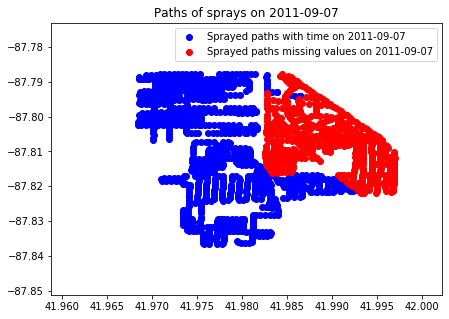

In [85]:
plt.figure(figsize=(7,5))
plt.title('Paths of sprays on 2011-09-07')
plt.scatter(data=spray2['2011-09'],x='Latitude',y='Longitude',color='blue',label='Sprayed paths with time on 2011-09-07')
plt.scatter(data=spray2[spray2['Time'].isnull()],x='Latitude',y='Longitude',color='red',label='Sprayed paths missing values on 2011-09-07')
plt.legend()

    The missing can be seen to be from one particular spray path, likely to be by one particular 'Sprayer'

C:\Users\himyn\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


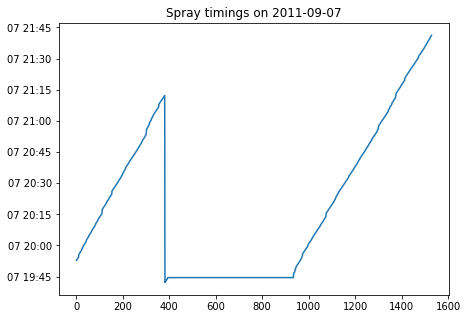

In [86]:
plt.figure(figsize=(7,5))
plt.title('Spray timings on 2011-09-07')
plt.plot(spray2['2011-09'].index)

In [87]:
spray2['Time']=pd.to_datetime(spray2['Time'])

In [88]:
spray2['2011-09']['Time'].diff().describe()

count                      1529
mean     0 days 00:00:04.249836
std      0 days 00:02:18.624730
min           -1 days +22:30:00
25%             0 days 00:00:00
50%             0 days 00:00:10
75%             0 days 00:00:10
max             0 days 00:01:58
Name: Time, dtype: object

In [89]:
spray2['2011-09']['Time'].describe()

count                    1530
unique                    989
top       2019-12-16 19:44:32
freq                      541
first     2019-12-16 19:42:12
last      2019-12-16 21:41:10
Name: Time, dtype: object

### Imputing missing time data
    We see that the time for continuous sprays is always split by 10 second increments. We impute the values as shown, starting from the earlier time on the same spray date and increasing by 10 seconds for each entry.

    First we calculate the time taken for the spray assuming 10 seconds for each spray

In [90]:
spray2[spray2['Time'].isnull()].shape

(584, 4)

In [91]:
#584 entries
Tp =583*10 #10 seconds each
Tpm= Tp/60 #convert to minutes
Tph= int(Tpm/60) #hours
Tpm= int(Tpm-Tph*60) #remaining time in mintues
Tps= (Tp%60) #remaining time in seconds

print(f'{Tp} seconds = {Tph} hour {Tpm} minutes {Tps} seconds')

5830 seconds = 1 hour 37 minutes 10 seconds


In [92]:
start = pd.Timestamp('2011-09-07 19:42:12')
end = pd.Timestamp('2011-09-07 21:19:22') #added manually to find the end time
t = np.linspace(start.value, end.value, 584)
t = pd.to_datetime(t)

In [93]:
t=pd.DataFrame(t,columns=['Time'])
t['Time']=pd.to_datetime(t['Time'])
t


,Time
0,2011-09-07 19:42:12
1,2011-09-07 19:42:22
2,2011-09-07 19:42:32
3,2011-09-07 19:42:42
4,2011-09-07 19:42:52
5,2011-09-07 19:43:02
6,2011-09-07 19:43:12
7,2011-09-07 19:43:22
8,2011-09-07 19:43:32
9,2011-09-07 19:43:42


### Create dataset of missing value to replace and later merge

In [94]:
spray3=pd.read_csv('Datasets/spray.csv') 
spray3=pd.DataFrame(spray3[spray3['Time'].isnull()])

In [95]:
t['Time']=pd.to_datetime(t['Time']) 

In [96]:
spray3.head()

,Date,Time,Latitude,Longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014


### Drop time column and replace it with imputed values

In [97]:
spray3=spray3.drop('Time',axis=1)

In [98]:
spray3=spray3.reset_index()

In [99]:
spray3['Time']=t['Time'].astype(str)

In [100]:
spray3=spray3.set_index('index')

In [101]:
spray3['Time']=pd.to_datetime(spray3['Time'])
spray3=spray3.drop('Date',axis=1)
spray3.columns=['Latitude','Longitude','Datetime']

In [102]:
spray3.head()

,Latitude,Longitude,Datetime
index,,,
1030,41.987092,-87.794286,2011-09-07 19:42:12
1031,41.987620,-87.794382,2011-09-07 19:42:22
1032,41.988004,-87.794574,2011-09-07 19:42:32
1033,41.988292,-87.795486,2011-09-07 19:42:42
1034,41.988100,-87.796014,2011-09-07 19:42:52


In [103]:
spray=pd.read_csv('Datasets/spray.csv')
print(spray.shape)
spray.dropna(inplace=True)
print(spray.shape)

(14835, 4)
(14251, 4)


In [104]:
spray['Datetime']=spray['Date']+' '+spray['Time']
spray['Datetime']=spray['Datetime'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %I:%M:%S %p') if x==x else x)
spray=spray.drop(['Date','Time'],axis=1)

In [105]:
finalspray=pd.concat([spray,spray3])
finalspray.shape

(14835, 3)

In [106]:
finalspray.iloc[1032:1045,:]

,Latitude,Longitude,Datetime
1616,41.973435,-87.829073,2011-09-07 19:46:50
1617,41.973442,-87.829835,2011-09-07 19:47:00
1618,41.973418,-87.830568,2011-09-07 19:47:10
1619,41.973482,-87.831098,2011-09-07 19:47:20
1620,41.973537,-87.831167,2011-09-07 19:47:50
1621,41.973443,-87.828427,2011-09-07 19:48:40
1622,41.973452,-87.827772,2011-09-07 19:48:50
1623,41.973455,-87.827173,2011-09-07 19:49:00
1624,41.973483,-87.826790,2011-09-07 19:49:10
1625,41.973985,-87.827068,2011-09-07 19:49:50


## Feature Engineering

### Try to cluster the groups by area

In [107]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [108]:
# Write your function to scale data here.
def scale_matrix(X):
    ss=StandardScaler()
    X=ss.fit_transform(X)
    return X
# Write a function that will plot the results of the three
# clustering algorithms for comparison.

# Your function should take TWO INPUTS:
# 1 - The data
# 2 - The clusterer

# Your function should do TWO THINGS:
# 1 - Print the SILHOUETTE SCORE for your clusters
# 2 - Plot the clusteres with appropriate coloring

def plot_results(df, cl,n):
    
    X = df.loc[:,:]
        # Scale data
    X_sc=scale_matrix(X)
        
    # Fit clusterer
    scoremeans=[]
    for y in range(2,n):
        score=[]
        
        for x in range(0,10):
            cl.n_clusters=y
            cl.fit(X_sc)
            score.append(silhouette_score(X_sc, cl.labels_))
        scoremean=np.mean(score)
        scoremeans.append(scoremean)
        #print(score)
        #print(f'Silhoutte Score for KMean {y}: {scoremean}')
    print(scoremeans)
    df['cluster'] = cl.labels_
    num_color=(len(set((cl.labels_))))
    
    # Plot
    plt.figure(figsize=(8,8))
    plt.title('Silhoutte score of '+str(cl))
    plt.plot(range(2,n),scoremeans)
    
    pass


    


In [109]:
cluster=df[df['Id'].isnull()].groupby('Trap')['Latitude','Longitude','NumMosquitos','WnvPresent'].mean()

In [110]:
df.head()

,AddressAccuracy,Date,Id,Latitude,Longitude,NumMosquitos,Trap,WnvPresent,Month_6,Month_7,...,Month_9,Month_10,Species_other,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Row Count,St1Dist,St2Dist,Station_1
0,9,2007-05-29,NaN,41.954690,-87.800991,1.0,T002,0.0,0,0,...,0,0,0,0,1,0,0.0,0.138026,0.175660,1
1,9,2007-05-29,NaN,41.954690,-87.800991,1.0,T002,0.0,0,0,...,0,0,0,0,0,1,0.0,0.138026,0.175660,1
2,9,2007-05-29,NaN,41.994991,-87.769279,1.0,T007,0.0,0,0,...,0,0,0,0,0,1,0.0,0.163721,0.209704,1
3,8,2007-05-29,NaN,41.974089,-87.824812,1.0,T015,0.0,0,0,...,0,0,0,0,1,0,0.0,0.110190,0.201691,1
4,8,2007-05-29,NaN,41.974089,-87.824812,4.0,T015,0.0,0,0,...,0,0,0,0,0,1,0.0,0.110190,0.201691,1


[0.33559969259178046, 0.31447004971193326, 0.2979573630748281, 0.3016334750750758, 0.27169347174328395, 0.25887221806616034, 0.25826645181309027, 0.26489923732488746, 0.26019217742314527, 0.26446468727758227, 0.27444554936279764, 0.2739039288942943, 0.2773902042978428, 0.28214570897647073, 0.2836508577441104, 0.28417103005352384, 0.28460349410398156, 0.2911273355868796]
[0.2499171904576872, 0.29481418574428536, 0.31959515871876587, 0.3485889571176686, 0.35084972974585116, 0.36741699885534895, 0.37245140574795166, 0.35197017572523037, 0.3624032953688747, 0.37465930597225444, 0.3804112774867056, 0.38909579868748745, 0.3920161338153649, 0.4031175472030476, 0.40223052636367973, 0.40532571818808927, 0.40967266574333766, 0.4001425564693274]


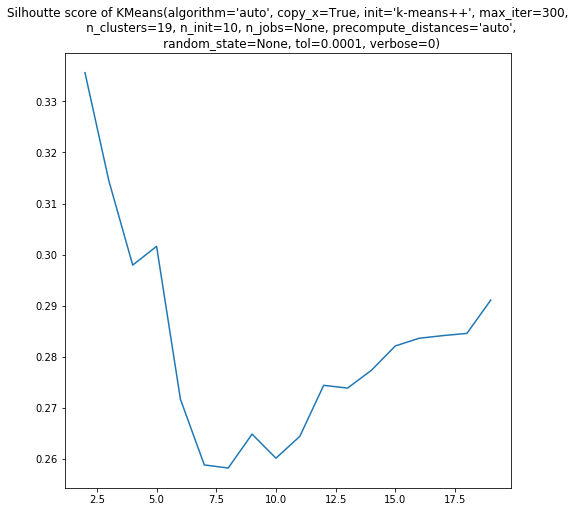

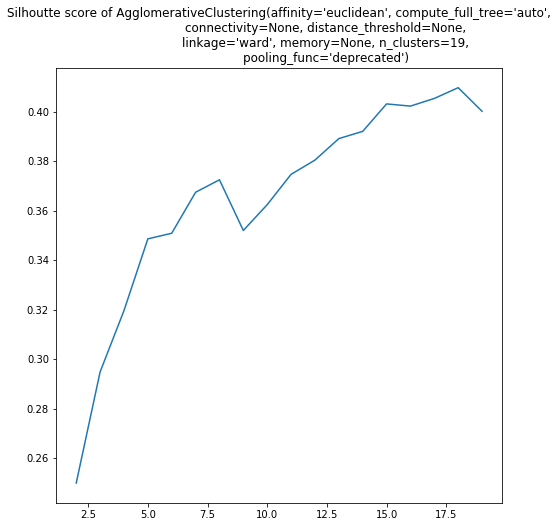

In [111]:
# A: 

np.random.seed(37)

plot_results(cluster,KMeans(),20)
plot_results(cluster,AgglomerativeClustering(),20)
#plot_results(cluster,DBSCAN(eps=1.5,min_samples=10))

A silhoutte score of less than 0.4 across the board shows that clustering does not give meaningful data. In addition the clusters were unstable between iterations. Thus we will not use this data.

### Engineering NumMosquitos from RowCount
    From our EDA, we see that NumMosquitos is a strong predictors of the presence of West Nile Virus. Unfortunately despite being present in the train set, this data is not collected in the test set. 
    
    There is some information given on how the collection data is organised that gives some clues on the number of mosquitos collected in the test set: every time the number of mosquitos of a particular species exceeds 50, a new row is created for it. This suggests that there should be a strong relationship between the number of rows and the number of mosquitos trapped for a particular day for a particular trap.
    
    We investigate if there is a strong enough relationship to predict the number of mosquitos from this data

In [112]:
mosq1 = pd.read_csv('Datasets/train.csv')
mosq1 = mosq1.join(mosq1.groupby(['Trap', 'Date', 'Species'])[
                   'Latitude'].count(), on=['Trap', 'Date', 'Species'], rsuffix='_r')

mosq1 = mosq1[['Trap', 'Date', 'NumMosquitos',
               'Latitude_r', 'WnvPresent', 'Species']]
mosq1.columns = ['Trap', 'Date', 'M/row', 'Row Count', 'WnvPresent', 'Species']

mosq1['Species_other']=df[df['Id'].isnull()]['Species_other'].values

In [113]:
mosq1.corr()['Row Count'].sort_values(ascending=False)

Row Count        1.000000
M/row            0.558638
WnvPresent       0.060320
Species_other   -0.052663
Name: Row Count, dtype: float64

In [114]:
mosq1.groupby('Species_other')['M/row'].mean()

Species_other
0    13.185163
1     2.123810
Name: M/row, dtype: float64

Since we are sure that only the transmitting mosquitos are important, we focus our efforts on predicting Number of mosquitos on the transmitting species

In [115]:
mosq1=mosq1[mosq1['Species_other']==0]

In [116]:
mosq2 = mosq1.groupby(['Row Count']).mean()
mosq2

,M/row,WnvPresent,Species_other
Row Count,,,
1,7.260307,0.041768,0.0
2,19.371681,0.081858,0.0
3,23.177177,0.099099,0.0
4,27.885870,0.059783,0.0
5,23.668293,0.043902,0.0
6,28.801587,0.103175,0.0
7,32.035714,0.107143,0.0
8,30.491667,0.108333,0.0
9,42.685185,0.074074,0.0


In [117]:
mosq2=mosq2.reset_index()

    From the data dictionary, we see that a new row is started everytime the number of mosquitos exceeds 50, therefore the average mosquito per row cannot exceed 50. As the number of rows increase, the average number of mosquitos should also increase. Assuming the final entry of each row is random and evenly distributed, the M/row should follow the formula:
    
    50*(N-1)+np.random.randint(1,50)/(N)
    
    Where N=the row number

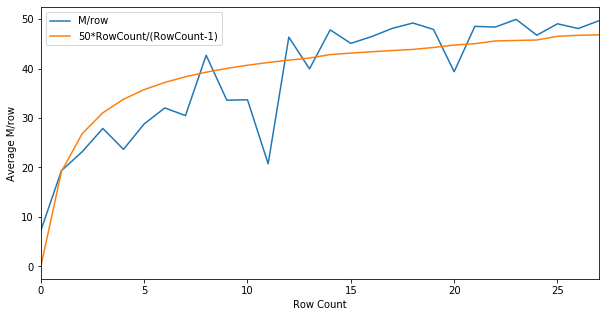

In [118]:
plt.figure(figsize=(10,5))
mosq2['M/row'].plot()
mosq2['Row Countm']=mosq2['Row Count'].apply(lambda x: x**0.7)
((50*mosq2['Row Countm']-50)/(mosq2['Row Countm'])).plot(label='50*RowCount/(RowCount-1)')
plt.xlabel('Row Count')
plt.ylabel('Average M/row')
plt.legend()

In [119]:
mosq1['Row Count^0.5']=mosq1['Row Count'].apply(lambda x: (x-1)/(x) )
mosq1.corr()

,M/row,Row Count,WnvPresent,Species_other,Row Count^0.5
M/row,1.000000,0.557488,0.193646,NaN,0.656909
Row Count,0.557488,1.000000,0.058274,NaN,0.662854
WnvPresent,0.193646,0.058274,1.000000,NaN,0.088833
Species_other,NaN,NaN,NaN,NaN,NaN
Row Count^0.5,0.656909,0.662854,0.088833,NaN,1.000000


In [120]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


X = mosq1['Row Count'].apply(lambda x: (x-1)/(x))
X = sm.add_constant(X.values)

y = mosq1['M/row']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=105)
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f'R^2: {lr.score(X_test,y_test)}')

R^2: 0.47410940686833464


    However, although the correlation between NumMosquitos and RowCount is significant, it is not high enough to do imputation, as it would be misleading even if it added predictive power. In effect an imputation would be similiar to using RowCount as a predictor, which we decide to do instead.

In [121]:
mosqtrain=pd.read_csv('Datasets/train.csv')
mosqtest=pd.read_csv('Datasets/test.csv')

mosqfinal=pd.concat([mosqtrain,mosqtest])

mosqfinal=mosqfinal.join(mosqfinal.groupby(['Trap','Date','Species'])['Latitude'].count(), on=['Trap','Date','Species'], rsuffix='_r')

mosqfinal=mosqfinal[['Trap','Date','NumMosquitos','Latitude_r','WnvPresent','Species']]

mosqfinal.columns=['Trap','Date','M/row','Row Count','WnvPresent','Species']


df1['Row Count']=mosqfinal['Row Count'].apply(lambda x: (x-1)/(x)).values

C:\Users\himyn\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [122]:
train=df1[df1['Id'].isnull()]
test=df1[df1['Id'].notnull()]
test=df1[df1['Id'].notnull()]
test=test.drop(['WnvPresent','Id'],axis=1)
train=train.drop('Id',axis=1)

# EDA

## Mosquitos

In [123]:
# we reloaded the unprocessed train here to show the reasons why we encode species 
# and show interesting stuff!

oldtrain = pd.read_csv('datasets/train.csv')

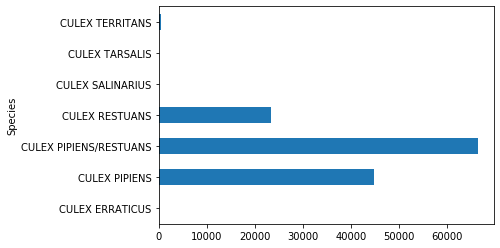

In [124]:
oldtrain.groupby('Species')['NumMosquitos'].sum().plot(kind='barh')

The main species in chicago area are: Pipiens, Pipiens/Restuans & Restuans. The no of mosquitos of other species are too low to even be seen.

In [125]:
oldtrain.groupby(by=['Species','WnvPresent'])['NumMosquitos'].sum()

Species                 WnvPresent
CULEX ERRATICUS         0                 7
CULEX PIPIENS           0             37942
                        1              6729
CULEX PIPIENS/RESTUANS  0             59145
                        1              7123
CULEX RESTUANS          0             22764
                        1               667
CULEX SALINARIUS        0               145
CULEX TARSALIS          0                 7
CULEX TERRITANS         0               510
Name: NumMosquitos, dtype: int64

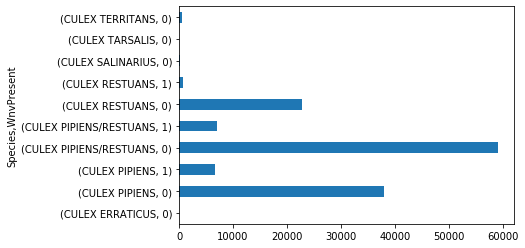

In [126]:
oldtrain.groupby(by=['Species','WnvPresent'])['NumMosquitos'].sum().plot(kind='barh')

Based on the table, we are able to tell that outside the 3 main culex, the rest dont cause WNV.

Based on the graph above, we can infer the infection rate of the different mosquitos could be different and hence we left the 3 species as such instead of encode them into 1 feature.

In [127]:
oldtrain['Date'] = pd.to_datetime(oldtrain['Date'], format='%Y-%m-%d')
oldtrain.set_index('Date',inplace= True)

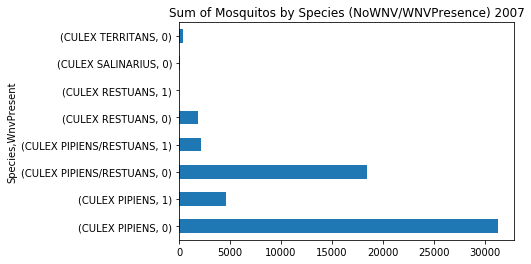

In [128]:
oldtrain['2007'].groupby(by=['Species','WnvPresent'])['NumMosquitos'].sum().plot(
    kind='barh', title='Sum of Mosquitos by Species (NoWNV/WNVPresence) 2007')

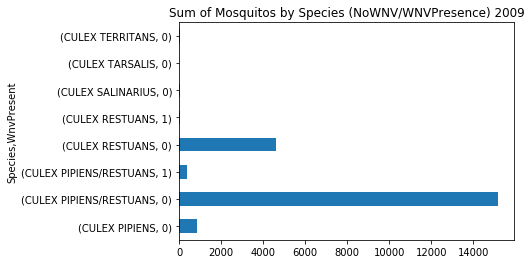

In [129]:
# plot 2
oldtrain['2009'].groupby(by=['Species','WnvPresent'])['NumMosquitos'].sum().plot(
    kind='barh', title='Sum of Mosquitos by Species (NoWNV/WNVPresence) 2009')

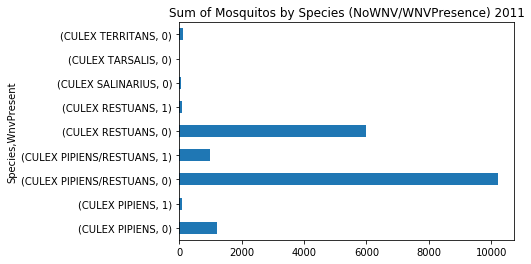

In [130]:
# plot 3
oldtrain['2011'].groupby(by=['Species','WnvPresent'])['NumMosquitos'].sum().plot(
    kind='barh', title='Sum of Mosquitos by Species (NoWNV/WNVPresence) 2011')

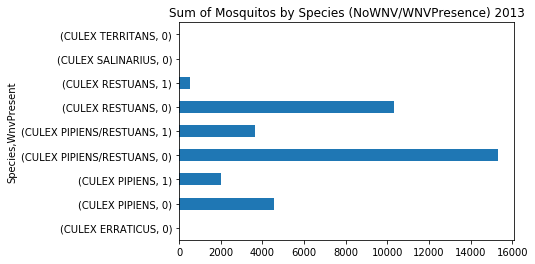

In [131]:
# plot 4
oldtrain['2013'].groupby(by=['Species','WnvPresent'])['NumMosquitos'].sum().plot(
    kind='barh', title='Sum of Mosquitos by Species (NoWNV/WNVPresence) 2013')

**Interestingly, Pipiens is not a WNV vector for 2009.**

## Correlations

In [132]:
train=df1[df1['Id'].isnull()]
test=df1[df1['Id'].notnull()]
test=test.drop(['WnvPresent','Id'],axis=1)
train=train.drop('Id',axis=1)
Wnv_corr = abs(train.corr()["WnvPresent"]).sort_values(ascending=False) #absolute values of correlations


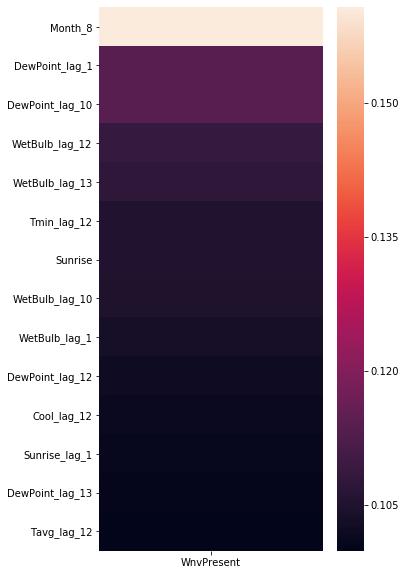

In [133]:
Wnv_corr2=Wnv_corr[Wnv_corr>0.08][:15] #correlations more than .1
Wnv_corr2=Wnv_corr2.drop('WnvPresent')
plt.figure(figsize=(5,10))
sns.heatmap(pd.DataFrame(Wnv_corr2)) 

**The above weather features are the most correlated with WNVpresent.**

## Spray Data

In [134]:
spray["Datetime"].dt.year.value_counts()

2013    12626
2011     1625
Name: Datetime, dtype: int64

    Sprays were only conducted in 2011 and 2013

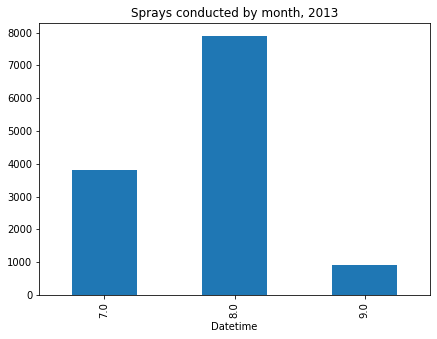

In [135]:
plt.figure(figsize=(7,5))
spray.groupby(spray[spray["Datetime"].dt.year==2013]["Datetime"].dt.month).count()['Longitude'].plot(kind="bar",title="Sprays conducted by month, 2013")

**On the precision of the longtitude and latitudes:**
The first decimal place is worth up to 11.1 km: it can distinguish the position of one large city from a neighboring large city.  
The second decimal place is worth up to 1.1 km: it can separate one village from the next.  
The third decimal place is worth up to 110 m: it can identify a large agricultural field or institutional campus.  
The fourth decimal place is worth up to 11 m: it can identify a parcel of land. It is comparable to the typical   accuracy of an uncorrected GPS unit with no interference.  
The fifth decimal place is worth up to 1.1 m: it distinguish trees from each other. Accuracy to this level with commercial GPS units can only be achieved with differential correction.  

**It is most likely that the sprays are GPS tracked, and are unlikely to give more than the 4th decimial place in accuracy. We should change the precision to reflect that.**

**Assumption: To determine if an area(and thus a Trap) has been sprayed we only need to determine if a village level area has been sprayed. We make this assumption that spraying is done at a town level by public agencies, and that if one property in a town has been sprayed, so will the rest.
  


In [136]:
spray['Latitude'].values

array([42.39162333, 42.39134833, 42.39102167, ..., 42.00602167,
       42.00545333, 42.004805  ])

In [137]:
spray['Latitude']=spray['Latitude'].map(lambda x: round(x,4)) #round values to 4 decimal place
spray['Longitude']=spray['Longitude'].map(lambda x: round(x,4)) #round values to 4 decimal place
spray['Latitude2']=spray['Latitude'].map(lambda x: round(x,2)) #round values to 2 decimal place
spray['Longitude2']=spray['Longitude'].map(lambda x: round(x,2)) #round values to 2 decimal place

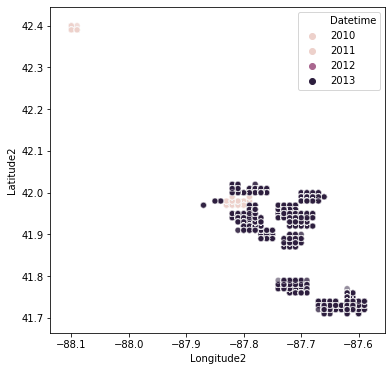

In [138]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=spray['Longitude2'],y=spray['Latitude2'],hue=spray["Datetime"].dt.year,alpha=0.5)

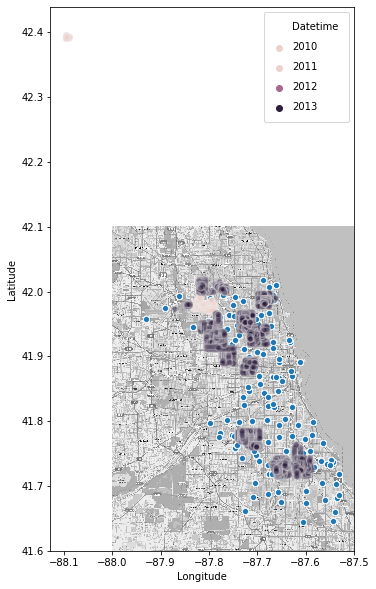

In [139]:
cmap=sns.color_palette('Set2',4)


mapdata = np.loadtxt("./datasets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(14,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)



sns.scatterplot(x=df['Longitude'],y=df['Latitude'])
sns.scatterplot(x=spray['Longitude'],y=spray['Latitude'],hue=spray["Datetime"].dt.year,alpha=0.1)
plt.legend(borderpad=1,labelspacing=1,handlelength=1)

    We notice some spraying outside the immediate area. Is this spraying relevant to the mosquitos caught in the traps?

In [140]:
spray['Latitude2'].describe()

count    14251.000000
mean        41.901359
std          0.105176
min         41.710000
25%         41.780000
50%         41.940000
75%         41.980000
max         42.400000
Name: Latitude2, dtype: float64

In [141]:
df['Latitude'].describe()

count    126799.000000
mean         41.848705
std           0.107139
min          41.644612
25%          41.753391
50%          41.862292
75%          41.951866
max          42.017430
Name: Latitude, dtype: float64

    No. We drop the spray counts outside of the trap area

In [142]:
spray=spray[spray['Latitude2']<42.2] #drop spray counts outside trap area

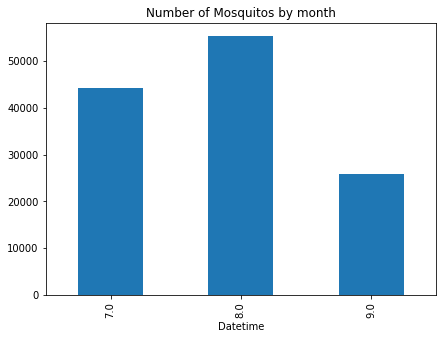

In [143]:
plt.figure(figsize=(7,5))
df.groupby(spray["Datetime"].dt.month).sum()['NumMosquitos'].plot(kind="bar",title='Number of Mosquitos by month')

**August lead the mosquite counts.**

In [144]:
df['Latitude'].values

array([41.95469 , 41.95469 , 41.994991, ..., 41.925652, 41.925652,
       41.925652])

## Trap Data
**The data only covers the months from May to October, likely the season of concern when the WNV is known to have outbreaks**

In [145]:
df.groupby(df["Date"].dt.month).sum() #sum by month

,AddressAccuracy,Id,Latitude,Longitude,NumMosquitos,WnvPresent,Month_6,Month_7,Month_8,Month_9,Month_10,Species_other,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Row Count,St1Dist,St2Dist,Station_1
Date,,,,,,,,,,,,,,,,,,,
5,666,0.000000e+00,3.514839e+03,-7.365829e+03,230.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,42,38,0.0,25.165849,13.144267,17
6,167647,1.022083e+09,8.809078e+05,-1.845906e+06,16578.0,1.0,21049.0,0.0,0.0,0.0,0.0,12121,2498,3192,3238,0.0,6057.945599,3114.047143,3648
7,304345,1.725820e+09,1.601630e+06,-3.356168e+06,37248.0,46.0,0.0,38271.0,0.0,0.0,0.0,21982,4771,6009,5509,0.0,11054.546084,5666.041359,6571
8,292095,2.075278e+09,1.542724e+06,-3.232886e+06,58036.0,377.0,0.0,0.0,36866.0,0.0,0.0,20500,5562,6055,4749,0.0,10760.817317,5466.510712,6188
9,220996,1.718421e+09,1.164651e+06,-2.440525e+06,21029.0,125.0,0.0,0.0,0.0,27830.0,0.0,15932,3971,4380,3547,0.0,8068.709853,4112.868010,4681
10,21439,2.204872e+08,1.129465e+05,-2.366827e+05,1918.0,2.0,0.0,0.0,0.0,0.0,2699.0,1523,414,433,329,0.0,787.197127,395.502456,434


### Plot of Mosquitos Caught and WNV infected mosquitos caught by month and year

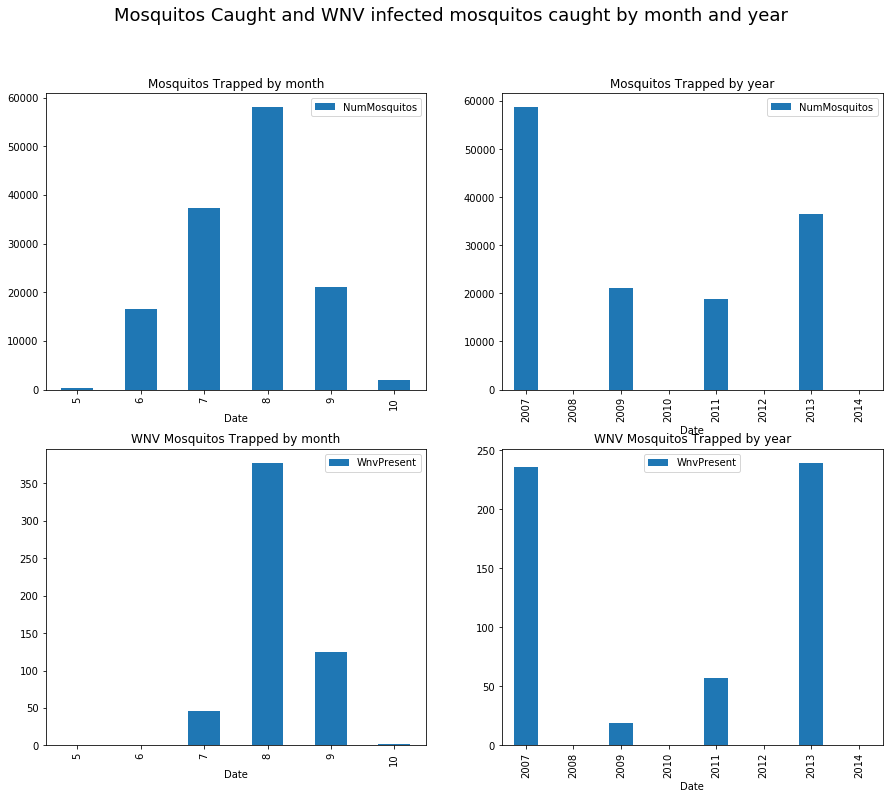

In [146]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,12))
fig.suptitle('Mosquitos Caught and WNV infected mosquitos caught by month and year',fontsize=18)
df.groupby(df["Date"].dt.month).sum()[['NumMosquitos']].plot(kind="bar",title='Mosquitos Trapped by month',ax=ax[0][0])
df.groupby(df["Date"].dt.year).sum()[['NumMosquitos']].plot(kind="bar",title='Mosquitos Trapped by year',ax=ax[0][1])

df.groupby(df["Date"].dt.month).sum()[['WnvPresent']].plot(kind="bar",title='WNV Mosquitos Trapped by month',ax=ax[1][0])
df.groupby(df["Date"].dt.year).sum()[['WnvPresent']].plot(kind="bar",title='WNV Mosquitos Trapped by year',ax=ax[1][1])

From this plot we can see that the number of WNV mosquitos caught is highly correlated to the number of WNV mosquitos caught

In [147]:
wnv=df.groupby([df["Date"].dt.year,df["Date"].dt.month]).sum()['WnvPresent'] # sum wnvpresent count by year and month
spraying=spray.groupby([spray["Datetime"].dt.year,spray["Datetime"].dt.month]).count()['Longitude'] # sum count of spray by month and year

In [148]:
wnv=pd.DataFrame(wnv)
wnv #count of wmvpresent by year and month

WnvPresent
Date Date            
2007 5            0.0
     6            0.0
     7            6.0
     8          200.0
     9           28.0
     10           2.0
2008 6            0.0
     7            0.0
     8            0.0
     9            0.0
2009 5            0.0
     6            0.0
     7            5.0
     8            9.0
     9            5.0
     10           0.0
2010 6            0.0
     7            0.0
     8            0.0
     9            0.0
     10           0.0
2011 6            0.0
     7           11.0
     8           24.0
     9           22.0
2012 6            0.0
     7            0.0
     8            0.0
     9            0.0
2013 6            1.0
     7           24.0
     8          144.0
     9           70.0
2014 6            0.0
     7            0.0
     8            0.0
     9            0.0
     10           0.0

In [149]:
spraying #count of spraying by year and month

Datetime  Datetime
2011      9           1530
2013      7           3809
          8           7893
          9            924
Name: Longitude, dtype: int64

In [150]:
wnv["Sprays conducted"]=spraying/50
wnv.columns=["Wnv mosquitos trapped","Sprays conducted"]

### Plot of Number of Mosquitos caught and Sprays conducted by month

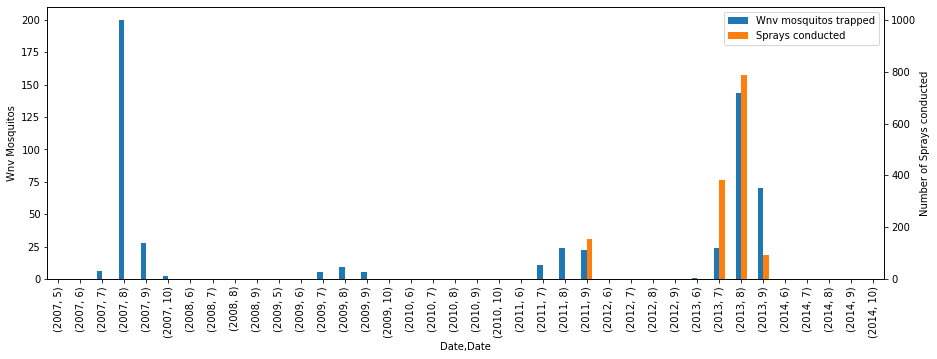

In [151]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Year, Month')
ax1.set_ylabel('Wnv Mosquitos')
wnv[['Wnv mosquitos trapped','Sprays conducted']].plot(kind='bar',ax=ax1)
ax1.set_ylim(bottom=0,top=210)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('Number of Sprays conducted', color=color)  # we already handled the x-label with ax1
ax2.set_ylim(bottom=0,top=1050)

ax2.tick_params(axis='y', labelcolor=color)

**There is only spraying data for 2011 and 2013. Most likely it means that spraying was done in 2012 as well, but no data is available to us, thus it will be hard to use this data without imputing spraying data for the entire 2012**

## Splitting the data into mosquitos caught by trap location

In [152]:
trap_loc=pd.DataFrame(df[['Trap','Latitude','Longitude']]).drop_duplicates() #drop multiple duplicate entries

In [153]:
train2=df[df['Id'].isnull()] #

In [154]:
months=[6,7,8,9,10]
years=[2007,2009,2011,2013]
trap_loc_new=pd.DataFrame()
for year in years:
    for month in months:
        name='NumMosquitos'
        mosbytrap=dict(train2[(train2["Date"].dt.month==month)&(train2["Date"].dt.year==year)].groupby('Trap').sum()['NumMosquitos'])
        wnvbytrap=dict(train2[(train2["Date"].dt.month==month)&(train2["Date"].dt.year==year)].groupby('Trap').sum()['WnvPresent'])
        new_entry=pd.DataFrame(trap_loc)
        new_entry['NumMosquitos']=trap_loc['Trap'].map(mosbytrap)
        new_entry['WnvCount']=trap_loc['Trap'].map(wnvbytrap)
        new_entry['animation_frame']=str(year)+'-'+str(month) 
        new_entry['Year']=year
        new_entry['Month']=month
        trap_loc_new=pd.concat([trap_loc_new,new_entry])

In [155]:
trap_loc_new.head() #dataframe of the details of trap

,Trap,Latitude,Longitude,NumMosquitos,WnvCount,animation_frame,Year,Month
0,T002,41.954690,-87.800991,17.0,0.0,2007-6,2007,6
2,T007,41.994991,-87.769279,5.0,0.0,2007-6,2007,6
3,T015,41.974089,-87.824812,7.0,0.0,2007-6,2007,6
5,T045,41.921600,-87.666455,6.0,0.0,2007-6,2007,6
6,T046,41.891118,-87.654491,10.0,0.0,2007-6,2007,6


In [156]:
trap_loc_new.fillna(0,inplace=True) #imnoute zero

In [157]:
spray['Year']=spray['Datetime'].dt.year #impute year
spray['Month']=spray['Datetime'].dt.month #impute month
spray['Day']=spray['Datetime'].dt.day #impte day

In [158]:
spray['animation_frame']=spray['Year'].astype(str)+'-'+spray['Month'].astype(str) #combine year and month

In [159]:
spray.head()

,Latitude,Longitude,Datetime,Latitude2,Longitude2,Year,Month,Day,animation_frame
95,41.9814,-87.7878,2011-09-07 19:52:52,41.98,-87.79,2011,9,7,2011-9
96,41.9810,-87.7878,2011-09-07 19:53:02,41.98,-87.79,2011,9,7,2011-9
97,41.9806,-87.7878,2011-09-07 19:53:12,41.98,-87.79,2011,9,7,2011-9
98,41.9802,-87.7878,2011-09-07 19:53:22,41.98,-87.79,2011,9,7,2011-9
99,41.9798,-87.7878,2011-09-07 19:53:32,41.98,-87.79,2011,9,7,2011-9


In [160]:
def generate_scatterplot(month,year):
    mapdata = np.loadtxt("datasets/mapdata_copyright_openstreetmap_contributors.txt") 

    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    plt.figure(figsize=(14,10))
    plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
    af=str(year)+'-'+str(month)
    sizemax=trap_loc_new[trap_loc_new['animation_frame']==af]['WnvCount'].max()
    sns.scatterplot(data=trap_loc_new[trap_loc_new['animation_frame']==af],x='Longitude',y='Latitude',size='WnvCount',sizes=(1,sizemax*50),alpha=0.6,color='red')
    sns.scatterplot(data=spray[spray['animation_frame']==af],x='Longitude2',y='Latitude2',alpha=0.1)

In [161]:
interact(generate_scatterplot, month = (6,9,1), year=(2011,2013,2) )

interactive(children=(IntSlider(value=7, description='month', max=9, min=6), IntSlider(value=2011, description…

<function __main__.generate_scatterplot(month, year)>

**Red dot represent traps with WNV present while blue dots represent spray conducted. As shown, in 2011, wnv appears in July but spraying effort only started in September. While in 2013, wnv appears in June and spraying effort started in July. Spraying effort only started as a response to the wnv.**

## Analysing Impact of spraying

In [162]:
finalspray.head()

,Latitude,Longitude,Datetime
0,42.391623,-88.089163,2011-08-29 18:56:58
1,42.391348,-88.089163,2011-08-29 18:57:08
2,42.391022,-88.089157,2011-08-29 18:57:18
3,42.390637,-88.089158,2011-08-29 18:57:28
4,42.390410,-88.088858,2011-08-29 18:57:38


Assign a trap location to each spray, IF spray is within a certain distance. See if this works first

In [163]:
finalspray['Latdiff']=finalspray['Latitude'].diff() #latitude difference from next point
finalspray['Longdiff']=finalspray['Longitude'].diff() #llongtitude difference from next point

In [164]:
finalspray['Distance']=np.sqrt(finalspray['Latdiff']**2+finalspray['Longdiff']**2)

In [165]:
finalspray.Distance.describe()

count    14834.000000
mean         0.000847
std          0.006650
min          0.000000
25%          0.000434
50%          0.000544
75%          0.000673
max          0.512505
Name: Distance, dtype: float64

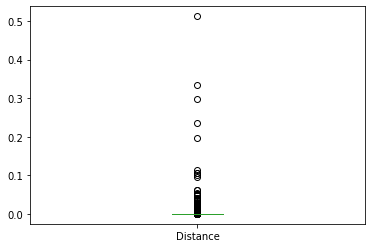

In [166]:
finalspray.Distance.plot(kind='box')

In [167]:
(finalspray.Distance<0.001).value_counts()/len(finalspray.Distance)

True     0.944523
False    0.055477
Name: Distance, dtype: float64

    95% of the sprays were within 0.001 distance from each other. Converted to metres, this is an effective range of 110m per spray

In [168]:
trap_loc.head()

,Trap,Latitude,Longitude,NumMosquitos,WnvCount,animation_frame,Year,Month
0,T002,41.954690,-87.800991,NaN,NaN,2013-10,2013,10
2,T007,41.994991,-87.769279,NaN,NaN,2013-10,2013,10
3,T015,41.974089,-87.824812,NaN,NaN,2013-10,2013,10
5,T045,41.921600,-87.666455,NaN,NaN,2013-10,2013,10
6,T046,41.891118,-87.654491,NaN,NaN,2013-10,2013,10


Assign each spray a trap location according to proximity.


In [169]:
traplist=[x for x in list(trap_loc['Trap'])]
latlist=[x for x in list(trap_loc['Latitude'])]
longlist=[x for x in list(trap_loc['Longitude'])]

In [170]:
def chkdist(lat1,long1,lat2,long2):
    return np.sqrt((lat1-lat2)**2+(long1-long2)**2)

In [171]:
def fintrap(lat,long,latlist=latlist,longlist=longlist,traplist=traplist):
    distlist=[]
    sprayedlist=[]
    traps=[]
    for index,x in enumerate(latlist):
        distance=chkdist(lat,long,x,longlist[index])
        distlist.append(distance)
        if distance<0.0008:
            sprayedlist.append(distance)
            
    indexed=distlist.index(min(distlist))
    
    if len(sprayedlist)>0:
        for x in sprayedlist:
            traps.append(traplist[distlist.index(x)])
        return traps 
        #print (f'Trap= {traps[0]} distance= {sprayedlist[0]}')
    else: pass
    

In [172]:
finalspray.head()

,Latitude,Longitude,Datetime,Latdiff,Longdiff,Distance
0,42.391623,-88.089163,2011-08-29 18:56:58,NaN,NaN,NaN
1,42.391348,-88.089163,2011-08-29 18:57:08,-0.000275,0.000000,0.000275
2,42.391022,-88.089157,2011-08-29 18:57:18,-0.000327,0.000007,0.000327
3,42.390637,-88.089158,2011-08-29 18:57:28,-0.000385,-0.000002,0.000385
4,42.390410,-88.088858,2011-08-29 18:57:38,-0.000227,0.000300,0.000376


In [173]:
finalspray.dtypes

Latitude            float64
Longitude           float64
Datetime     datetime64[ns]
Latdiff             float64
Longdiff            float64
Distance            float64
dtype: object

In [174]:
finalspray

,Latitude,Longitude,Datetime,Latdiff,Longdiff,Distance
0,42.391623,-88.089163,2011-08-29 18:56:58,NaN,NaN,NaN
1,42.391348,-88.089163,2011-08-29 18:57:08,-0.000275,0.000000,0.000275
2,42.391022,-88.089157,2011-08-29 18:57:18,-0.000327,0.000007,0.000327
3,42.390637,-88.089158,2011-08-29 18:57:28,-0.000385,-0.000002,0.000385
4,42.390410,-88.088858,2011-08-29 18:57:38,-0.000227,0.000300,0.000376
5,42.390395,-88.088315,2011-08-29 18:57:48,-0.000015,0.000543,0.000544
6,42.390673,-88.088002,2011-08-29 18:57:58,0.000278,0.000313,0.000419
7,42.391027,-88.088002,2011-08-29 18:58:08,0.000353,0.000000,0.000353
8,42.391403,-88.088003,2011-08-29 18:58:18,0.000377,-0.000002,0.000377
9,42.391718,-88.087995,2011-08-29 18:58:28,0.000315,0.000008,0.000315


In [175]:
fintrap(42.391623,-88.089163)

In [176]:
effsprays=[]
efftimes=[]
tlist=[]
for x in range(len(finalspray['Latitude'])):
    lat=finalspray['Latitude'].iloc[x]
    long=finalspray['Longitude'].iloc[x]
    dt=finalspray['Datetime'].iloc[x]
    tlist=fintrap(lat,long)
    if tlist:
        for y in tlist:
            effsprays.append(y)
            efftimes.append(dt)
        

In [177]:
#only 104 effective sprays were counted
len(effsprays)

104

In [178]:
sprayedtraps=list(set(effsprays))

In [179]:
len(sprayedtraps) #number of sprayed traps

27

In [180]:
len(trap_loc) #out of 151 trap locations

151

In [181]:
spraydict={x:[] for x in sprayedtraps}

In [182]:
for index,x in enumerate(effsprays):
    spraydict[x].append(efftimes[index])

In [183]:
spraydict

{'T085': [Timestamp('2013-07-17 21:36:27'), Timestamp('2013-07-17 21:36:57')],
 'T015': [Timestamp('2011-09-07 19:54:10'),
  Timestamp('2011-09-07 19:54:50'),
  Timestamp('2011-09-07 20:51:10')],
 'T151': [Timestamp('2013-08-15 21:34:55'), Timestamp('2013-08-15 21:35:15')],
 'T001': [Timestamp('2013-07-25 21:02:56')],
 'T223': [Timestamp('2011-09-07 20:57:52'),
  Timestamp('2011-09-07 20:58:02'),
  Timestamp('2011-09-07 20:58:12')],
 'T159': [Timestamp('2013-07-17 21:20:27'),
  Timestamp('2013-07-17 21:22:37'),
  Timestamp('2013-07-17 21:22:47'),
  Timestamp('2013-07-17 21:34:27')],
 'T014': [Timestamp('2011-09-07 19:57:12'),
  Timestamp('2011-09-07 19:57:22'),
  Timestamp('2011-09-07 19:57:32')],
 'T089': [Timestamp('2013-07-17 21:28:17')],
 'T044': [Timestamp('2013-08-22 22:01:15'),
  Timestamp('2013-08-22 22:01:25'),
  Timestamp('2013-08-22 22:01:35'),
  Timestamp('2013-08-22 22:02:05'),
  Timestamp('2013-08-22 22:02:15')],
 'T156': [Timestamp('2013-08-29 20:34:23'),
  Timestamp('20

In [184]:
newtrain=pd.DataFrame(df[df['Id'].isnull()])#create new trainset to attach spray data
newtrain['SprayDates']=newtrain['Trap'].map(spraydict) #assign list of spraying dates to individual entries
newtrain=newtrain[newtrain['Date'].dt.year>2010]#spraying only done in 2011 onwards
newtrain=newtrain[newtrain['SprayDates'].notnull()]#drop traps without spraying

In [185]:
#for each spray date, minus the date of the sample taken to get a timedelta for each spray
newtrain['Timedelta']=[[newtrain.iloc[index,1]-y for y in x] for index,x in enumerate(newtrain['SprayDates'])]

In [186]:
newtrain

,AddressAccuracy,Date,Id,Latitude,Longitude,NumMosquitos,Trap,WnvPresent,Month_6,Month_7,...,Species_other,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Row Count,St1Dist,St2Dist,Station_1,SprayDates,Timedelta
6069,8,2011-06-10,NaN,41.916265,-87.800515,1.0,T151,0.0,1,0,...,0,0,0,1,0.0,0.154115,0.139006,0,"[2013-08-15 21:34:55, 2013-08-15 21:35:15]","[-798 days +02:25:05, -798 days +02:24:45]"
6071,8,2011-06-10,NaN,41.948167,-87.730698,1.0,T218,0.0,1,0,...,0,0,0,1,0.0,0.207652,0.163560,0,"[2013-07-25 21:11:16, 2013-07-25 21:11:26, 201...","[-777 days +02:48:44, -777 days +02:48:34, -77..."
6082,9,2011-06-10,NaN,41.940160,-87.794896,3.0,T144,0.0,1,0,...,0,0,1,0,0.0,0.148594,0.160017,1,"[2013-08-15 21:59:18, 2013-08-15 21:59:28, 201...","[-798 days +02:00:42, -798 days +02:00:32, -79..."
6118,9,2011-06-10,NaN,41.973845,-87.805059,2.0,T223,0.0,1,0,...,0,0,1,0,0.0,0.129678,0.195195,1,"[2011-09-07 20:57:52, 2011-09-07 20:58:02, 201...","[-90 days +03:02:08, -90 days +03:01:58, -90 d..."
6119,9,2011-06-10,NaN,41.904194,-87.756155,4.0,T230,0.0,1,0,...,0,0,0,1,0.0,0.198796,0.118267,0,"[2013-08-15 21:32:56, 2013-08-15 21:33:06]","[-798 days +02:27:04, -798 days +02:26:54]"
6131,8,2011-06-17,NaN,41.732984,-87.649642,7.0,T159,0.0,1,0,...,0,0,0,1,0.0,0.385933,0.115273,0,"[2013-07-17 21:20:27, 2013-07-17 21:22:37, 201...","[-762 days +02:39:33, -762 days +02:37:23, -76..."
6141,8,2011-06-17,NaN,41.932094,-87.700117,2.0,T147,0.0,1,0,...,0,0,1,0,0.0,0.241229,0.155033,0,[2013-08-08 21:33:44],[-784 days +02:26:16]
6142,8,2011-06-17,NaN,41.932094,-87.700117,3.0,T147,0.0,1,0,...,0,0,0,1,0.0,0.241229,0.155033,0,[2013-08-08 21:33:44],[-784 days +02:26:16]
6143,8,2011-06-17,NaN,41.932094,-87.700117,1.0,T147,0.0,1,0,...,1,0,0,0,0.0,0.241229,0.155033,0,[2013-08-08 21:33:44],[-784 days +02:26:16]
6144,8,2011-06-17,NaN,41.916265,-87.800515,23.0,T151,0.0,1,0,...,0,0,1,0,0.0,0.154115,0.139006,0,"[2013-08-15 21:34:55, 2013-08-15 21:35:15]","[-791 days +02:25:05, -791 days +02:24:45]"


In [187]:
#take the timedelta with the smallest absolute time delta 
newtrain['Timedelta']=newtrain['Timedelta'].apply(lambda i: i[[abs(a) for a in i].index(min([abs(a) for a in i]))])

In [188]:
newtrain=newtrain[abs(newtrain['Timedelta'])<pd.to_timedelta('30 days')]


In [189]:
newtrain['Deltadays']=newtrain['Timedelta'].apply(lambda x: x.days)

C:\Users\himyn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([ 5.,  6.,  7.,  0.,  0.,  0.,  0.,  7.,  3.,  4.,  0.,  1.,  0.,
         0., 11.,  3.,  1.,  0.,  0.,  0.,  3.,  0., 13.,  7.,  6.,  0.,
         0.,  0.,  0.,  5.,  2., 11.,  0.,  0.,  2.,  0., 11.,  7.,  2.,
         0.,  0.,  0.,  0.,  0.,  6., 10.,  3.,  0.,  0.,  0.,  0.,  6.,
        13.,  2.,  0.,  0.,  0.,  0.,  6.,  9.]),
 array([-29.  , -28.05, -27.1 , -26.15, -25.2 , -24.25, -23.3 , -22.35,
        -21.4 , -20.45, -19.5 , -18.55, -17.6 , -16.65, -15.7 , -14.75,
        -13.8 , -12.85, -11.9 , -10.95, -10.  ,  -9.05,  -8.1 ,  -7.15,
         -6.2 ,  -5.25,  -4.3 ,  -3.35,  -2.4 ,  -1.45,  -0.5 ,   0.45,
          1.4 ,   2.35,   3.3 ,   4.25,   5.2 ,   6.15,   7.1 ,   8.05,
          9.  ,   9.95,  10.9 ,  11.85,  12.8 ,  13.75,  14.7 ,  15.65,
         16.6 ,  17.55,  18.5 ,  19.45,  20.4 ,  21.35,  22.3 ,  23.25,
         24.2 ,  25.15,  26.1 ,  27.05,  28.  ]),
 <a list of 60 Patch objects>)

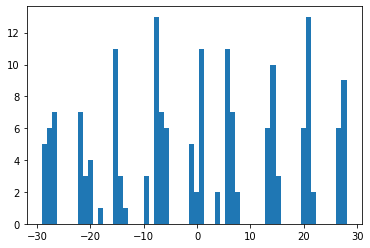

In [190]:
#histogram of the timedelta from spray to collection dates
plt.hist(newtrain['Timedelta'].apply(lambda x: x.days),bins=60)

In [191]:
a=newtrain.groupby(['Trap','Date'])['NumMosquitos','WnvPresent'].sum()
b=newtrain.groupby(['Trap','Date'])['Deltadays'].mean()

In [192]:
pd.DataFrame(b).head()

Deltadays
Trap Date                 
T008 2013-06-21        -27
     2013-06-27        -21
     2013-07-08        -10
     2013-07-12         -6
     2013-07-19          1

In [193]:
pd.DataFrame(a).head(20)

NumMosquitos  WnvPresent
Trap Date                                
T008 2013-06-21           8.0         0.0
     2013-06-27           2.0         0.0
     2013-07-08          42.0         0.0
     2013-07-12          78.0         2.0
     2013-07-19         245.0         1.0
     2013-07-25         118.0         0.0
     2013-08-01         174.0         0.0
     2013-08-08         165.0         0.0
     2013-08-15          59.0         0.0
T009 2011-09-23           1.0         0.0
T089 2013-06-21          26.0         0.0
     2013-06-28          10.0         0.0
     2013-07-08          10.0         0.0
     2013-07-12          11.0         0.0
     2013-07-19          11.0         0.0
     2013-07-25          10.0         0.0
     2013-08-01           9.0         0.0
     2013-08-08           8.0         1.0
     2013-08-15           9.0         0.0
T147 2013-07-12          28.0         0.0

In [194]:
c=pd.merge(a,b,on=['Trap','Date'])

In [195]:
c=c.reset_index()

In [196]:
c.head()

,Trap,Date,NumMosquitos,WnvPresent,Deltadays
0,T008,2013-06-21,8.0,0.0,-27
1,T008,2013-06-27,2.0,0.0,-21
2,T008,2013-07-08,42.0,0.0,-10
3,T008,2013-07-12,78.0,2.0,-6
4,T008,2013-07-19,245.0,1.0,1


In [197]:
d=c.groupby('Deltadays',).mean()

In [198]:
e=c.groupby('Deltadays')['NumMosquitos'].count()

In [199]:
f=pd.merge(d,e,on='Deltadays')

In [200]:
f.columns=['NumMosquitos','WnvPresent','Count']

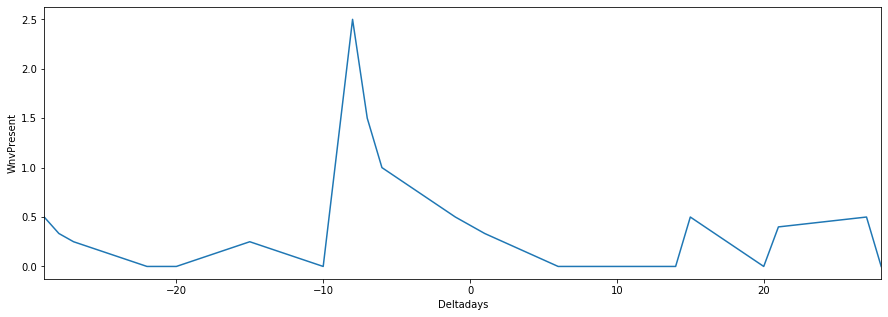

In [201]:
plt.figure(figsize=(15,5))
plt.ylabel('WnvPresent')
f[f['Count']>1]['WnvPresent'].plot()

In [202]:
thislist=set(c['Trap'])

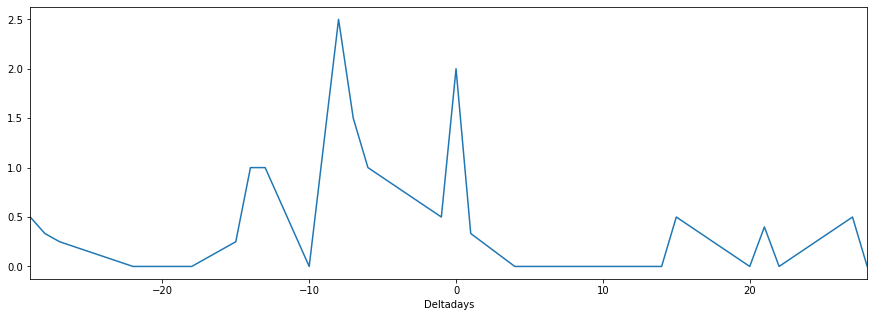

In [203]:
plt.figure(figsize=(15,5))
c.groupby('Deltadays')['WnvPresent'].mean().plot()

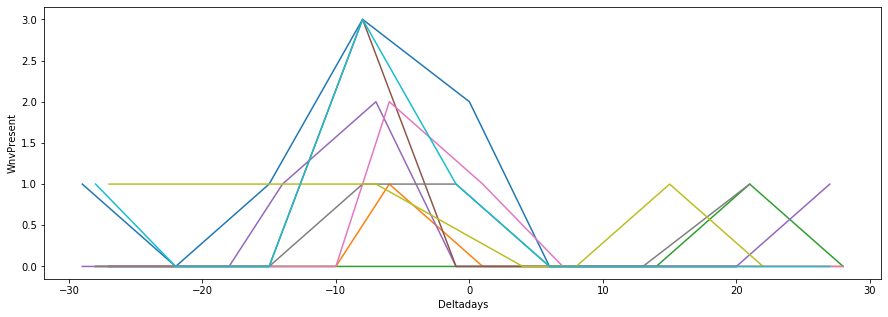

In [204]:
plt.figure(figsize=(15,5))
for a in thislist:
    #sns.lineplot(data=c[c['Trap']==a],x='Deltadays',y='NumMosquitos')
    sns.lineplot(data=c[c['Trap']==a],x='Deltadays',y='WnvPresent')


# Prediction

## Feature Selection

### 1st model (No lag features)

In [205]:
X_features_no_lag = [
    'Species_other',
 'Species_CULEX PIPIENS',
 'Species_CULEX PIPIENS/RESTUANS',
 'Species_CULEX RESTUANS',
 'Tmax',
 'Tmin',
 'Tavg',
 'Depart',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'Sunrise',
 'Sunset',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'code_FG',
 'code_MIFG',
 'code_DZ',
 'code_VCFG',
 'code_RA',
 'code_VCTS',
 'code_BR',
 'code_FG+',
 'code_HZ',
 'code_GR',
 'code_SQ',
 'code_BCFG',
 'code_TS',
 'code_FU',
 'code_TSRA',
 'code_SN',
'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Row Count', 
]

In [206]:
train.columns

Index(['WnvPresent', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Species_other', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       ...
       'code_RA_lag_14', 'code_DZ_lag_14', 'code_TS_lag_14',
       'code_TSRA_lag_14', 'code_VCTS_lag_14', 'code_SN_lag_14',
       'code_HZ_lag_14', 'code_VCFG_lag_14', 'code_FG+_lag_14',
       'code_BCFG_lag_14'],
      dtype='object', length=491)

In [207]:
X = train[X_features_no_lag]
y = train['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

In [208]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [209]:
def model_assessor(model, X_test, y_test):
    '''
    Plots an ROC, with AUC score and other relevant metrics
    '''
    predictions = model.predict(X_test)
    confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    accuracy = (tn+tp)/(tn+ fp+ fn+ tp)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    
    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    # points of the ROC
    roc_auc = auc(fpr, tpr)
    # calculate AUC score
    

    fig = plt.figure(figsize=(12,7))
    plt.plot(fpr, tpr, 'b', label = f'AUC = {round(roc_auc,2)}')

    plt.plot([0, 1], [0, 1], color ='red', label='baseline',
             linestyle='--')
    plt.legend(loc = 'lower right',fontsize=15)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.title('Receiver Operating Characteristic',fontsize=15)
    plt. text(0.5, 0.2, 
              f'''
              True Negatives: {tn}
              False Positives: {fp}
              False Negatives: {fn}
              True Positives: {tp}
              
              accuracy: {accuracy}
              recall: {recall}
              specificity: {specificity}
              precision: {precision}
              '''
              , horizontalalignment='center', verticalalignment='center',fontsize = 13)
    #show accuracy, recall, specificity, precision and confusion matrix on the graph
    plt.show()

#### Logistics Regression

In [210]:
lr_pipe = Pipeline([('stdscaler',StandardScaler()),
    ('lr',LogisticRegression(solver='liblinear'))])
lr_pipe_param = {'lr__C':[0.7,0.8,0.9,1.0],
                'lr__penalty':['l1'],
                }
lrgs = GridSearchCV(lr_pipe,param_grid=lr_pipe_param, cv=5,n_jobs=-1)
lrgs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('stdscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='wa

#### XGBoost

In [211]:
xgb_pipe = Pipeline([('stdscaler',StandardScaler()),
                     ('xgb',XGBClassifier(n_estimators=200, n_jobs=-1,eval_metric='auc'))])
xgb_pipe_param = {}
# xgb_pipe_param = {'xgb__max_delta_step':[0,1,2]}
xgbgs = GridSearchCV(xgb_pipe,param_grid=xgb_pipe_param, cv=10,n_jobs=-1,scoring='roc_auc')
xgbgs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('stdscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      eval_metric='auc',
                                                      gamma=0,
                                                      learning_rate=0.1,
                   

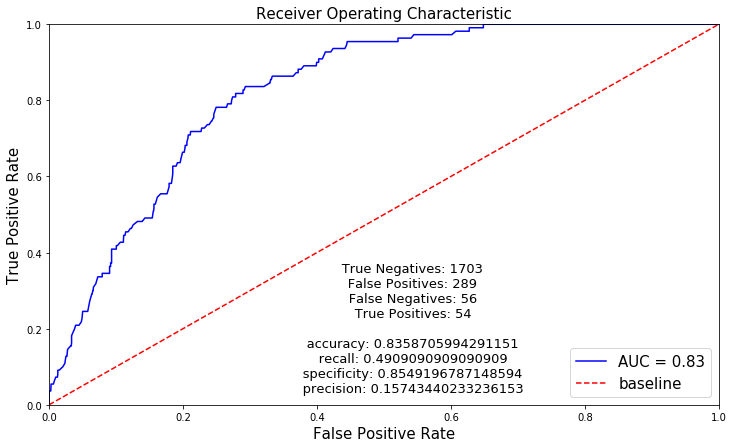

In [212]:
model_assessor(xgbgs, X_test, y_test)

In [214]:
sub=pd.DataFrame()
sub['Id']=df1[df1['Id'].notnull()]['Id']


sub['WnvPresent']=xgbgs.predict_proba(test[X_features_no_lag])[:,1]
sub['Id']=sub['Id'].astype(int)
sub.to_csv('Submissions/subxgb1.csv',index=False)

### Comparing correlations of all lag features to WnvPresent

In [217]:
Wnv_corr_rcount = abs(train.corr()["WnvPresent"]).sort_values(ascending=False)
for x,y in Wnv_corr_rcount.items(): 
    print(f'{x}                       {y}')
    print('------------------------------')

WnvPresent                       1.0
------------------------------
Month_8                       0.16065283413703374
------------------------------
DewPoint_lag_1                       0.11403036342537284
------------------------------
DewPoint_lag_10                       0.11395817060329803
------------------------------
WetBulb_lag_12                       0.10850096987337729
------------------------------
WetBulb_lag_13                       0.10731665608529585
------------------------------
Tmin_lag_12                       0.10523318376197817
------------------------------
Sunrise                       0.10522746024578028
------------------------------
WetBulb_lag_10                       0.10479117865869628
------------------------------
WetBulb_lag_1                       0.10363881163995313
------------------------------
DewPoint_lag_12                       0.10211756604488237
------------------------------
Cool_lag_12                       0.10154274664307901
--------------

In [218]:
all_corr = Wnv_corr_rcount[Wnv_corr_rcount>0].keys() #all keys with coreelation more than zero 
all_corr

Index(['WnvPresent', 'Month_8', 'DewPoint_lag_1', 'DewPoint_lag_10',
       'WetBulb_lag_12', 'WetBulb_lag_13', 'Tmin_lag_12', 'Sunrise',
       'WetBulb_lag_10', 'WetBulb_lag_1',
       ...
       'code_RA_lag_2', 'code_FG_lag_12', 'Tavg_lag_4', 'code_FU_lag_10',
       'Depart_lag_5', 'Depart_lag_6', 'ResultDir_lag_11', 'Cool_lag_3',
       'StnPressure_lag_8', 'code_RA_lag_10'],
      dtype='object', length=402)

In [219]:
high_corr = Wnv_corr_rcount[Wnv_corr_rcount>0][1:].keys() 
high_corr

Index(['Month_8', 'DewPoint_lag_1', 'DewPoint_lag_10', 'WetBulb_lag_12',
       'WetBulb_lag_13', 'Tmin_lag_12', 'Sunrise', 'WetBulb_lag_10',
       'WetBulb_lag_1', 'DewPoint_lag_12',
       ...
       'code_RA_lag_2', 'code_FG_lag_12', 'Tavg_lag_4', 'code_FU_lag_10',
       'Depart_lag_5', 'Depart_lag_6', 'ResultDir_lag_11', 'Cool_lag_3',
       'StnPressure_lag_8', 'code_RA_lag_10'],
      dtype='object', length=401)

In [220]:
all_cols = X_features_no_lag

#all_cols is the names of all the features without '_lag_'
keylist = all_cols 
Impt_vars = {} 
  

for k in keylist: 
    Impt_vars[(k+'_')] = []
# iterating through the elements of all_cols to create a dict with all_cols as the keys with no values 

for k,v in Impt_vars.items():
    for i in list(all_corr):
        if k == (i+'_')[:len(k)]:
            v.append(i)
# for each key in Impt_vars, append the next highest lag feature in all_corr
            
for k,v in Impt_vars.items():
    print(f'{k}:    {v[:5]}')
# for each key in Impt_vars, print the top 5 lag features

Species_other_:    ['Species_other']
Species_CULEX PIPIENS_:    ['Species_CULEX PIPIENS']
Species_CULEX PIPIENS/RESTUANS_:    ['Species_CULEX PIPIENS/RESTUANS']
Species_CULEX RESTUANS_:    ['Species_CULEX RESTUANS']
Tmax_:    ['Tmax_lag_13', 'Tmax_lag_12', 'Tmax_lag_8', 'Tmax_lag_10', 'Tmax_lag_14']
Tmin_:    ['Tmin_lag_12', 'Tmin_lag_1', 'Tmin_lag_13', 'Tmin_lag_8', 'Tmin_lag_14']
Tavg_:    ['Tavg_lag_12', 'Tavg_lag_13', 'Tavg_lag_8', 'Tavg_lag_14', 'Tavg_lag_1']
Depart_:    ['Depart_lag_1', 'Depart_lag_8', 'Depart_lag_2', 'Depart', 'Depart_lag_12']
DewPoint_:    ['DewPoint_lag_1', 'DewPoint_lag_10', 'DewPoint_lag_12', 'DewPoint_lag_13', 'DewPoint_lag_8']
WetBulb_:    ['WetBulb_lag_12', 'WetBulb_lag_13', 'WetBulb_lag_10', 'WetBulb_lag_1', 'WetBulb_lag_8']
Heat_:    ['Heat_lag_13', 'Heat_lag_8', 'Heat_lag_10', 'Heat_lag_14', 'Heat_lag_12']
Cool_:    ['Cool_lag_12', 'Cool_lag_13', 'Cool_lag_8', 'Cool_lag_14', 'Cool_lag_1']
Sunrise_:    ['Sunrise', 'Sunrise_lag_1', 'Sunrise_lag_4', 'Sunr

In [221]:
for k,v in Impt_vars.items():
    if len(v) == 0:
        pass
    else:
        print(f'---------------{k}------------------')
        print(Wnv_corr_rcount[v[:2]])
        print('-----------------')

---------------Species_other_------------------
Species_other    0.041362
Name: WnvPresent, dtype: float64
-----------------
---------------Species_CULEX PIPIENS_------------------
Species_CULEX PIPIENS    0.096206
Name: WnvPresent, dtype: float64
-----------------
---------------Species_CULEX PIPIENS/RESTUANS_------------------
Species_CULEX PIPIENS/RESTUANS    0.01096
Name: WnvPresent, dtype: float64
-----------------
---------------Species_CULEX RESTUANS_------------------
Species_CULEX RESTUANS    0.092094
Name: WnvPresent, dtype: float64
-----------------
---------------Tmax_------------------
Tmax_lag_13    0.096161
Tmax_lag_12    0.083256
Name: WnvPresent, dtype: float64
-----------------
---------------Tmin_------------------
Tmin_lag_12    0.105233
Tmin_lag_1     0.088004
Name: WnvPresent, dtype: float64
-----------------
---------------Tavg_------------------
Tavg_lag_12    0.099896
Tavg_lag_13    0.094177
Name: WnvPresent, dtype: float64
-----------------
---------------Depa

### 2nd Model (all lag features with abs corr with WnvPresent > 0)

**For the second model, I ran a log regression instead of xgboost as I wanted to intepret which of the following lags increased the probability of west nile virus the most.** 

In [222]:
X = train[high_corr]
y = train['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

In [223]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

#### Logistics Regression

In [224]:
lr_pipe = Pipeline([('stdscaler',StandardScaler()),
    ('lr',LogisticRegression(solver='liblinear'))])
lr_pipe_param = {'lr__C':[0.01,0.1,1,10],
                'lr__penalty':['l1'],
                }
lrgs = GridSearchCV(lr_pipe,param_grid=lr_pipe_param, cv=5,n_jobs=-1,scoring='roc_auc',verbose=1)
lrgs.fit(X_train, y_train)
lrgs.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min finished


{'lr__C': 10, 'lr__penalty': 'l1'}

In [225]:
lrgs.best_estimator_

Pipeline(memory=None,
         steps=[('stdscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

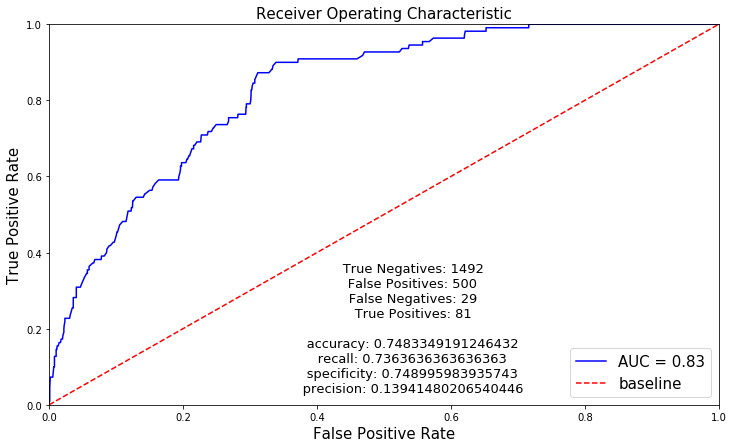

In [226]:
model_assessor(lrgs, X_test, y_test)

**Access the coefs used in the model, for use in the final model**

In [227]:
Log_reg_coef = lrgs.best_estimator_.named_steps['lr'].coef_.ravel()

In [228]:
not_zero_position = []
for i, coef in enumerate(list(Log_reg_coef)):

    
    if coef >0:
        not_zero_position.append(i)
       


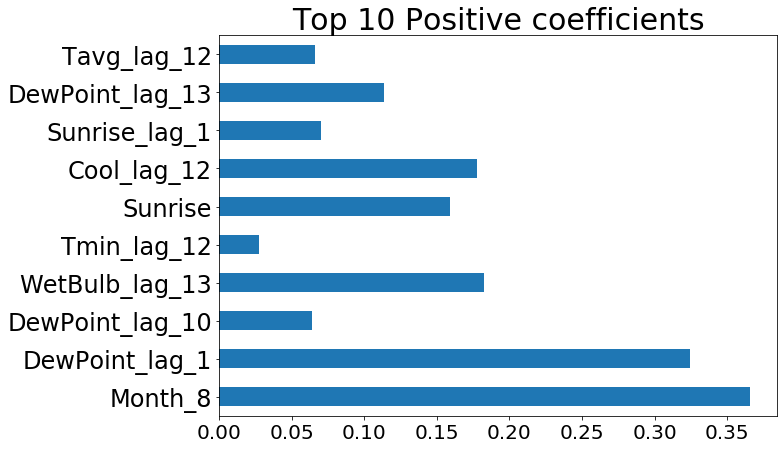

In [229]:

pd.Series(Log_reg_coef[Log_reg_coef>0][:10], index=high_corr[not_zero_position][:10]).plot.barh(figsize=(10, 7))
plt.title('Top 10 Positive coefficients',fontdict={'fontsize':30})
plt.xticks(fontsize=20);
plt.yticks(fontsize=24);

In [230]:
not_zero_position = []
for i, coef in enumerate(list(Log_reg_coef)):

    
    if coef <0:
        not_zero_position.append(i)
       


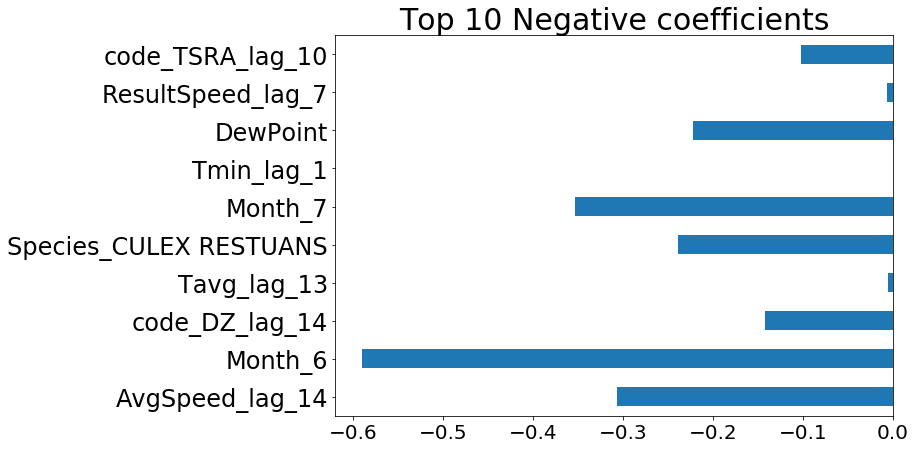

In [231]:
pd.Series(Log_reg_coef[Log_reg_coef<-0][:10], index=high_corr[not_zero_position][:10]).plot.barh(figsize=(10, 7))
plt.title('Top 10 Negative coefficients',fontdict={'fontsize':30})

plt.xticks(fontsize=20);
plt.yticks(fontsize=24);

#### Xgboost (for kaggle score)

In [232]:
xgb_pipe = Pipeline([('stdscaler',StandardScaler()),
                     ('xgb',XGBClassifier(n_estimators=200, n_jobs=-1,eval_metric='auc'))])
xgb_pipe_param = {}
# xgb_pipe_param = {'xgb__max_delta_step':[0,1,2]}
xgbgs = GridSearchCV(xgb_pipe,param_grid=xgb_pipe_param, cv=10,n_jobs=-1,scoring='roc_auc')
xgbgs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('stdscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      eval_metric='auc',
                                                      gamma=0,
                                                      learning_rate=0.1,
                   

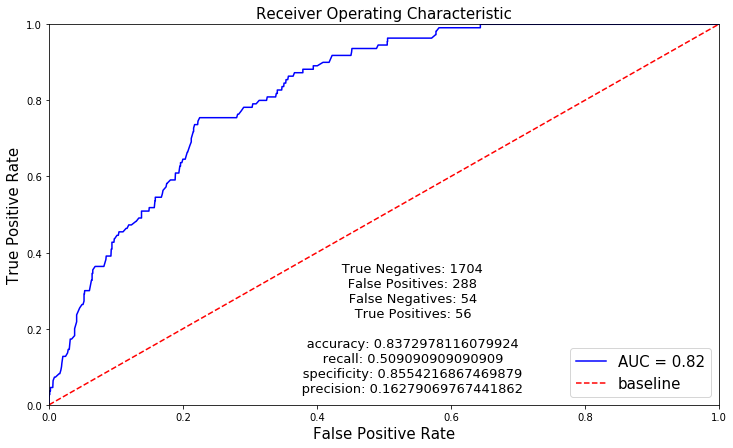

In [233]:
model_assessor(xgbgs, X_test, y_test)

In [234]:
sub=pd.DataFrame()
sub['Id']=df1[df1['Id'].notnull()]['Id']


sub['WnvPresent']=xgbgs.predict_proba(test[high_corr])[:,1]
sub['Id']=sub['Id'].astype(int)
sub.to_csv('Submissions/subxgbgs.csv',index=False)

### Third Model: Prediction on >10 days ago Features

    Prediction on previous day data is not useful in the sense that it takes time to organize a spray. We notice that the previous models use alot of data from 10-14 days before the collection date, which leads us to believe a useful model can be taken from this. We attempt to develop a model based on data taken 10 days before the trap collection.

In [235]:
df2=lag(10,14,df1)

    We create a dataframe with weather data from 10-14 days before the collection

In [236]:
df2.columns.values

array(['Id', 'WnvPresent', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Species_other', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Row Count', 'Tmax_lag_10', 'Tmin_lag_10', 'Tavg_lag_10',
       'Depart_lag_10', 'DewPoint_lag_10', 'WetBulb_lag_10',
       'Heat_lag_10', 'Cool_lag_10', 'Sunrise_lag_10', 'Sunset_lag_10',
       'PrecipTotal_lag_10', 'StnPressure_lag_10', 'SeaLevel_lag_10',
       'ResultSpeed_lag_10', 'ResultDir_lag_10', 'AvgSpeed_lag_10',
       'code_BR_lag_10', 'code_SQ_lag_10', 'code_FU_lag_10',
       'code_MIFG_lag_10', 'code_FG_lag_10', 'code_GR_lag_10',
       'code_RA_lag_10', 'code_DZ_lag_10', 'code_TS_lag_10',
       'code_TSRA_lag_10', 'code_VCTS_lag_10', 'code_SN_lag_10',
       'code_HZ_lag_10', 'code_VCFG_lag_10', 'code_FG+_lag_10',
       'code_BCFG_lag_10', 'Tmax_lag_11', 'Tmin_lag_11', 'Tavg_lag_11',
       'Depart_lag_11', 'DewPoint_lag_11', 'WetBulb_lag_11',
       'Heat_lag_1

In [237]:
train=df2[df2['Id'].isnull()] #training set does not contain id
test=df2[df2['Id'].notnull()] #only test set contains id
test=test.drop(['WnvPresent','Id'],axis=1) #drop columns wnvpresent column as it is null and id as it is not predictors
train=train.drop('Id',axis=1) #drop id as it is null

In [238]:
train.columns.values

array(['WnvPresent', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Species_other', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Row Count', 'Tmax_lag_10', 'Tmin_lag_10', 'Tavg_lag_10',
       'Depart_lag_10', 'DewPoint_lag_10', 'WetBulb_lag_10',
       'Heat_lag_10', 'Cool_lag_10', 'Sunrise_lag_10', 'Sunset_lag_10',
       'PrecipTotal_lag_10', 'StnPressure_lag_10', 'SeaLevel_lag_10',
       'ResultSpeed_lag_10', 'ResultDir_lag_10', 'AvgSpeed_lag_10',
       'code_BR_lag_10', 'code_SQ_lag_10', 'code_FU_lag_10',
       'code_MIFG_lag_10', 'code_FG_lag_10', 'code_GR_lag_10',
       'code_RA_lag_10', 'code_DZ_lag_10', 'code_TS_lag_10',
       'code_TSRA_lag_10', 'code_VCTS_lag_10', 'code_SN_lag_10',
       'code_HZ_lag_10', 'code_VCFG_lag_10', 'code_FG+_lag_10',
       'code_BCFG_lag_10', 'Tmax_lag_11', 'Tmin_lag_11', 'Tavg_lag_11',
       'Depart_lag_11', 'DewPoint_lag_11', 'WetBulb_lag_11',
       'Heat_lag_11', 'C

In [239]:
X = train.drop('WnvPresent',axis=1)
y = train['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

In [240]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

#### Logistics Regression

In [241]:
lr_pipe = Pipeline([('stdscaler',StandardScaler()),
    ('lr',LogisticRegression(solver='liblinear'))])
lr_pipe_param = {'lr__C':[0.01,0.1,1,10],
                'lr__penalty':['l1'],
                }
lrgs = GridSearchCV(lr_pipe,param_grid=lr_pipe_param, cv=5,n_jobs=-1,verbose=-1)
lrgs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('stdscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='wa

In [242]:
Log_reg_coef = lrgs.best_estimator_.named_steps['lr'].coef_.ravel()

In [243]:
hard_code_submission(df2,lrgs,name='1014hc.csv')

NameError: name 'hard_code_submission' is not defined

In [ ]:
predictions=lrgs.predict(X_test)
pd.DataFrame(confusion_matrix(y_test,predictions),columns=['Pred_Neg','Pred_Pos'],index=['Actual_Neg','Actual_Pos'])

    False Negative: 32  
    False Positive: 483
    
    True Positive: 78
    True Negative: 1509

#### XGBoost

In [ ]:
xgb_pipe = Pipeline([('stdscaler',StandardScaler()),
                     ('xgb',XGBClassifier(n_estimators=200, n_jobs=-1,eval_metric='auc'))])
xgb_pipe_param = {}
# xgb_pipe_param = {'xgb__max_delta_step':[0,1,2]}
xgbgs = GridSearchCV(xgb_pipe,param_grid=xgb_pipe_param, cv=10,n_jobs=-1,scoring='roc_auc')
xgbgs.fit(X_train, y_train)

In [ ]:
#set all entries where mosquitos are non-transmitters to zero(improved score by around .01 to .02)
def hard_code_submission(train_test,model,name='Submission.csv'):
    final_test_id= train_test.dropna(subset=['Id'].copy())
    final_train_id= train_test[train_test['Id'].isnull()]
    final_test=final_test_id.drop(['Id','WnvPresent'],axis=1)
    final_train=final_train_id.drop(['Id','WnvPresent'],axis=1)
    
    sub_test=final_test_id[final_test_id['Species_other']==0].copy()
    nt_test=final_test_id[final_test_id['Species_other']==1].copy()
    
    sub_test=sub_test[['Id']]
    nt_test=nt_test[['Id','Species_other']]
    nt_test.columns=['Id','WnvPresent']
    
    nt_test.WnvPresent=np.zeros(shape=(71743,))
    
    Submission = final_test_id[['Id']].copy().astype('int32')
    Submission['WnvPresent'] = model.predict_proba(final_test)[:,1]
    Submission=pd.merge(sub_test,Submission,how='left',on=['Id'])
    Submission=pd.concat([Submission,nt_test],axis=0,sort=False)
    Submission=Submission.sort_values('Id',ascending=True)
    Submission['Id']=Submission['Id'].astype('int32')
    Submission.to_csv(name,index=False)
    print('submission saved')
    return Submission

In [ ]:
model_assessor(xgbgs, X_test, y_test)

In [ ]:
hard_code_submission(df2,xgbgs,'xgbgshc1014.csv')

In [ ]:
predictions=xgbgs.predict(X_test)
pd.DataFrame(confusion_matrix(y_test,predictions),columns=['Pred_Neg','Pred_Pos'],index=['Actu_Neg','Actu_Pos'])

    False Negative: 53  
    False Positive: 295
    
    True Positive: 57
    True Negative: 1697

In [ ]:
KAGGLE SCORE: 0.76178

# Conclusion

**Dataset1: No lag on weather data**  
  
    Logistic Regression:0.70662  
    XGboost: 0.73676  
     
**Dataset2: All lag weather features from 1 to 14 days**  
  
    Logistic Regression:0.66436  
    XGboost: 0.74240  
    
**Dataset: 10-14 days old weather data**  
  
    Logistic Regression:0.63911
    XGboost: 0.76178

## Cost-benefit analysis

This should include annual cost projections for various levels of pesticide coverage (cost) and the effect of these various levels of pesticide coverage (benefit). *(Hint: How would we quantify the benefit of pesticide spraying? To get "maximum benefit," what does that look like and how much does that cost? What if we cover less and therefore get a lower level of benefit?)*
Cost part:
This should include annual cost projections for various levels of pesticide coverage (cost) and the effect of these various levels of pesticide coverage (benefit).


**From a cost-benefit point of view:**<br>
**Benefits of eradicating or lowering infection rate includes:**<br>
•	Reduction of direct initial medical costs & long-term medical cost<br>
•	Temporal productivity cost from missing work<br>
•	Loss in contribution to economy if illness results in death<br>
<br>
**Cost** <br>
•	Cost of Mosquito Vector control<br>


### Medical costs

In calculating the medical costs (direct initial medical costs & long-term medical cost), Staples et al (2010), they estimated the following:<br>
<br>
**A. Initial costs.**<br>
1. Direct hospital costs. 
2. Indirect costs. They assumed for hospitalized patients who missed work that they had a work schedule of 5 out of every 7 days and valued time lost from work. A further discount is applied if a participant worked part-time (50% daily production value).<br>

The lost productivity for persons who died during their initial hospitalization was derived from the lifetime production value discounted at 3% their age and sex. <br>

**B. Costs incurred in the 5 years after initial hospitalization if ND.**<br>
1. Medical appointments and institutional care costs. 
2. Drug costs. 
3. Durable medical equipment. Some of follow-up needed specific equipment after their hospital discharge. 
4. Indirect costs. Accounts for the number of days of missed employment in the long-term follow-up period.

The above is the cost in 2012 dollars and we inflated the price to Sep 2019 prices by using the CPI for All Urban Consumers: Medical Care in U.S. City Average. We then averaged the cost for fever & meningitis for non-neurological disease of WNV `$19,284.40` and averaged the cost for Encephalitis & AFP for neurological WNV `$163,181.00`.<br>
<br>
Based on data collected from the CDC website:

**The expect benefits per year (based on the average of last 5 years) would be $6,715,563.**


### Cost of Mosquito Vector control

In calculating the cost of vector control, we only studied cost done via truck-mounted fogging.<br>
<br>
According to the Illinois Department of Public Health, mosquito control  agencies usually use truck-mounted fogging units to apply synthetic pyrethroid insecticides as an ultra-low-volume (ULV) spray. ULV spray units dispense very fine aerosol droplets (fog) that stay aloft and kill mosquitoes on contact. The amount of insecticide sprayed by ULV units is small compared to the area treated, usually about 3 to 5 ounces per acre (1oz = 29.5735ml) and the area of interest in our project is Cook County which is about 4,235 km2 (1,046,491 acre). <br>
<br>
**A complete spray of the whole Cook County would require about  123,793.45L and that would cost $19,064,191.24.** <br>
<br>
As it would be impossible to even to spray to cover the whole state even ONCE and a more targeted approach would be needed.  Hence, we would recommend spraying based on <our model’s recommendation>**<br>
<br>



       The current model where sprays are conducted only after Wnv clusters are detected resulted in 12600 sprays, with each range assumed to be around 100m thats 126km^2 or 
       
                                 Current Cost of Spraying:**$567000**

    Our model that used 2 week old data, had the following confusion matrix:
    

In [ ]:
predictions=xgbgs.predict(X_test)
pd.DataFrame(confusion_matrix(y_test,predictions)/len(X_test),columns=['Pred_Neg','Pred_Pos'],index=['Actu_Neg','Actu_Pos'])

    False Negative rate: 0.025214  
    False Positive rate: 0.140343
    
    True Positive rate: 0.027117
    True Negative rate: 0.807326

If sprays were done at every predicted positive area, with each spray covering 0.25km^2,   
  
Spray rate =  **(FPrate+TPrate)**= **0.167**


In [ ]:
#With 147 traps and daily trap checking for 5 months in a year->
150*151

    
    22650 trap checks a year, with an spray rate of 0.167 and assumed coverage of 0.25km^2 and $4500/km^2


In [ ]:
22050*0.167*0.25*4500

     This costs 3.5 million more than the current model, but with 6.7 million in savings in medical costs, there is a clear benefit to using our model to guide spraying patterns.
     
    Medical Benefits=$6,715,563
    Current Spray Cost=$567000
    New Spray Cost= $4142643
    
    **Savings= $3139920**

 

In [ ]:
6715563+567000-4142643

In [ ]:
pred_prob=xgbgs.predict_proba(X_test)
predictions=pd.DataFrame(pred_prob>0.4)[1][:]

#### Limitations of the cost-benefit analysis.<br>
We are unable to properly account for monetary value of pain & suffering, distress or external help needed to perform daily task.  <br>
<br>
Some other projects online also talked about the possibility of loss in tourism dollars when the city sprays pesticide. We also did not factor this in as it is a tough question to try and model tourism arrivals when there is an epidemic.

# Sources:
1.	Staples J, Shankar M, Sejvar J, Meltzer M, Fischer M, , 2014. Initial and long-term costs of patients hospitalized with West Nile virus disease. Am J Trop Med Hyg 90: 402–409. DOI: https://doi.org/10.4269/ajtmh.13-0206 

2.	Arboviral surveillance data are reported to CDC through ArboNET. https://www.cdc.gov/westnile/statsmaps/

3.	CPI index for All Urban Consumers: Medical Care in U.S. City Average https://fred.stlouisfed.org/series/CPIMEDSL

4.	Specifications of a generic insecticide. https://www.epa.gov/mosquitocontrol/permethrin-resmethrin-d-phenothrin-sumithrinr-synthetic-pyrethroids-mosquito-control

5.	Price of a synthetic insecticide (Permethrin price) https://www.sigmaaldrich.com/catalog/product/sial/45614?lang=en&region=US

6.	Department of public health Illinois – Mosquito control. http://www.dph.illinois.gov/topics-services/environmental-health-protection/structural-pest-control/mosquito-spray-faqs
